**EDA**
* Correlation between host and athletes performance(does host select events? or just direct effect?) (overall and Gold)(ewa of previous, host, and next)
* Trend of number of medals over time
* Special sports for each country(pingpong China, basketball the USA)

**Data Proprocessing:**
* Handling historical data, Olympics in the early 20th century were vastly different from modern ones in terms of participation, number of events, etc. Countries that were dominant in earlier years may not reflect current or future trends. Global events like WWI influence Olympics. To handle it, use weighted importance, for example w_year = exp(-k(2028-year))
* Remove data for sports that are not in recent years.
* About year, use the recent 2-3 olympics as validation data. How to select the range for training? How to deal with years in WWI and WWII?
* Remove the athletes that are not in the 2020 and 2024 olympics, consider how to handle new athletes
* Rows are sport name, columns are country_medaltype, entries are ewa with param=0.8(average last 5 times, 20 years) for historical medal counts. Think about how do feature engineer and EDA

**Feature Engineering**
* Athletes' participation times to estimate age. EDA of distribution of ages of medals
* From Athletes_file, count medals for each sport of each country, sport as a column in medal_file, use this to replace medal_file(so rows number from original year times country to year times country times sport)
* 技术性或体力性
* KNN as denotation of GDP/population
* Athletes number vs medal counts. EDA, .corr()
* Group medals(divided by the number of members)

**Questions**
* Athletes attending 2028? new athletes?
* Which model is the best? What is the target? What is the format of the target?(1 Gold for each sport, then the best way is to make a prediction for each sport. However, it cannot be done due to the model complexity and the lack of 2028 gymnasts data.) If directly predict the medal counts, how to concatenate the dataframes/feature engineering?(One thought is summarize the athletes data for each country)
* Is there a limit of number of events an athletes can attend?(like attend in similar disciplines in a sport) What if some country dont have enough athletes.
* How to use athletes data combine with number of discipline

**Training Data Columns(If NN, using log for skewed features. Shift)** 
medals.columns, sport_type, 技术性或体力性?, ewa of medal counts as country specialization, average athletes score in recent 2 games, host country, Athletes number, KNN?(x=index,y=medal_count), athletes data?

A separate classifier for first time medal, remove China as outlier(EDA, large territory and population, which means large athletes pool)

**Great Coach**
* EDA or use medal counts for year t minus year (t-1) > 3.

**Training Data Structure type**
1. medals_file
2. medals_file.columns + sport_type
3. predict winning for each athlete(no athletes data for 2028)

distribution of medal

for athletes, medal counts divided by events counts

Use proportion for medal count, athletes count, 
ewa medal/event

Team members count


**Current Training Columns**
* Features: Host, Medal_EWA, Events, Athletes_Counts, Athletes_Proportion, NOC(replaced with KNN_Total),
 
Not using the classification for total medal count due to the highly skewed medal distribution(too many 0, make 0 precision high, but as more medals a Year, NOC, Sport_code, precision decreases.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from scipy.stats import ttest_ind, norm
from sklearn.feature_selection import mutual_info_regression
from sklearn.neighbors import NearestNeighbors
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_squared_error

import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Add, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


data_dict = pd.read_csv('/kaggle/input/2025-problem-c-data/2025_Problem_C_Data/data_dictionary.csv', encoding="latin-1")
athletes = pd.read_csv('/kaggle/input/2025-problem-c-data/2025_Problem_C_Data/summerOly_athletes.csv')
hosts = pd.read_csv('/kaggle/input/2025-problem-c-data/2025_Problem_C_Data/summerOly_hosts.csv')
medal = pd.read_csv('/kaggle/input/2025-problem-c-data/2025_Problem_C_Data/summerOly_medal_counts.csv')
programs = pd.read_csv('/kaggle/input/2025-problem-c-data/2025_Problem_C_Data/summerOly_programs.csv', encoding="latin-1")
hosts = hosts.drop(hosts.index[hosts['Year'].isin([1916, 1940, 1944])]) #Drop years during WW
athletes['NOC'] = athletes['NOC'].replace('AIN', 'ROC') #2024 ROC Team
programs.rename(columns={'1906*': '1906'}, inplace=True) #Replace 1906* as 1906
y_2028_sports = pd.read_csv('/kaggle/input/programs2028/summerOly_2028_Sports.csv')

In [21]:
def medal_count_for_each_sport(athletes):
    train = (
        athletes[['Year', 'NOC', 'Sport', 'Event', 'Medal']]
        .drop_duplicates()
        .groupby(['Year', 'NOC', 'Sport', 'Medal'])
        .size()
        .unstack(fill_value=0)
        .reset_index()
    ).sort_values(by=['Year', 'Gold', 'Silver', 'Bronze'], ascending=[False, False, False, False])
    
    athlete_count = (
        athletes[['Year', 'NOC', 'Sport', 'Name']]
        .drop_duplicates()
        .groupby(['Year', 'NOC', 'Sport'])
        .size()
        .reset_index(name='Athlete_Count')
    )
    
    sport_athlete_count = (
        athletes[['Year', 'Sport', 'Name']]
        .drop_duplicates()
        .groupby(['Year', 'Sport'])
        .size()
        .reset_index(name='Sport_Athlete_Count')
    )

    train = train.merge(athlete_count, on=['Year', 'NOC', 'Sport'], how='left')
    train = train.merge(sport_athlete_count, on=['Year', 'Sport'], how='left')

    train['Athlete_Proportion'] = train['Athlete_Count'] / train['Sport_Athlete_Count']

    train = train.loc[:, ['Year', 'NOC', 'Sport', 'Gold', 'Silver', 'Bronze', 'Athlete_Count', 'Sport_Athlete_Count', 'Athlete_Proportion']]
    return train.reset_index(drop=True)

def create_2028_rows(train):
    df_2028 = train[(train['Year'] >= 1999)]
    noc_sport_combinations = df_2028.groupby(['NOC', 'Sport']).size().reset_index()[['NOC', 'Sport']]
    new_rows = pd.DataFrame({
        'Year': 2028,
        'NOC': noc_sport_combinations['NOC'],
        'Sport': noc_sport_combinations['Sport'],
        'Gold': 0,
        'Silver': 0,
        'Bronze': 0,
        'Athlete_Count': 0,
        'Sport_Athlete_Count': 0,
        'Athlete_Proportion': 0.0
    })

    return pd.concat([new_rows, train], ignore_index=True)

def merge_hosts(train, hosts):
    new_row = pd.DataFrame({'Year': [1906], 'Host': ['Athens, Greece']}) # Add 1906 Host
    hosts = pd.concat([hosts, new_row], ignore_index=True)
    
    country_to_noc = {
        "United States": "USA",
        "United Kingdom": "GBR",
        "France": "FRA",
        "Australia": "AUS",
        "Japan": "JPN",
        "Germany": "GER",
        "Greece": "GRE",
        "Brazil": "BRA",
        "China": "CHN",
        "Spain": "ESP",
        "South Korea": "KOR",
        "Russia": "RUS",
        "Canada": "CAN",
        "Mexico": "MEX",
        "Italy": "ITA",
        "Finland": "FIN",
        "Netherlands": "NED",
        "Belgium": "BEL",
        "Sweden": "SWE",
    }    
    hosts['Country'] = hosts['Host'].str.split(',').str[-1].str.strip()
    hosts['NOC'] = hosts['Country'].map(country_to_noc)
    hosts.loc[hosts['Year'] == 1972, 'NOC'] = 'FRG'
    hosts.loc[hosts['Year'] == 1980, 'NOC'] = 'URS'
    hosts.loc[hosts['Year'] == 2020, 'NOC'] = 'JPN'
    hosts = hosts.drop(['Host', 'Country'], axis=1)

    train = pd.merge(train, hosts, on='Year', how='left', suffixes=('', '_host'))
    train['NOC'] = train['NOC'].replace({'RUS': 'ROC'})
    train['NOC_host'] = train['NOC_host'].replace({'RUS': 'ROC'})
    train['NOC_if_host'] = train.apply(lambda row: 1 if row['NOC'] == row['NOC_host'] else 0, axis=1)
    return train

def add_2028_sports(programs, y_2028_sports):
    programs['Discipline'] = programs['Discipline'].fillna(programs['Sport'])

    programs['Sport'] = programs['Sport'].str.replace('\xa0', ' ', regex=True)

    programs['Sport'] = programs['Sport'].str.lower()
    programs['Discipline'] = programs['Discipline'].str.lower()
    y_2028_sports['Sport'] = y_2028_sports['Sport'].str.lower()
    y_2028_sports['Discipline'] = y_2028_sports['Discipline'].str.lower()

    if '2028' not in programs.columns:
        programs = programs.merge(y_2028_sports, how='left', left_on=['Sport', 'Discipline'], right_on=['Sport', 'Discipline'])
        programs['2028'] = programs['2028'].fillna(0).astype(int)
        programs.loc[71, '2028'] = programs.loc[:70, '2028'].sum()
    else:
        print("2028 column already exists")
    return programs

def merge_programs(train, programs):
    sport_to_code_mapping = {
        'Athletics': 'ATH',
        'Hockey': 'HOC',
        'Football': 'FBL',
        'Wrestling': 'WRG',
        'Boxing': 'BOX',
        'Judo': 'JUD',
        'Taekwondo': 'TKW',
        'Shooting': 'SHO',
        'Swimming': 'SWM',
        'Cycling Road': 'CRD',
        'Weightlifting': 'WLF',
        'Fencing': 'FEN',
        'Synchronized Swimming': 'SWA',
        'Sailing': 'SAL',
        'Equestrianism': 'EDR',
        'Triathlon': 'TRI',
        'Cycling': 'CTR',
        'Artistic Gymnastics': 'GAR',
        'Gymnastics': 'GAR',
        'Handball': 'HBL',
        'Tennis': 'TEN',
        'Volleyball': 'VVO',
        'Rowing': 'ROW',
        'Table Tennis': 'TTE',
        'Trampolining': 'GTR',
        'Badminton': 'BDM',
        'Canoe Sprint': 'CSP',
        'Karate': 'KTE',
        'Marathon Swimming': 'OWS',
        'Canoe Slalom': 'CSL',
        'Canoeing': 'CSP', 
        'Basketball': 'BKB',
        'Beach Volleyball': 'VBV',
        'Rugby': 'RUG',
        'Diving': 'DIV',
        'Figure Skating': 'FSK',
        'Polo': 'POL',
        'Water Polo': 'WPO',
        'Art Competitions': None,
        'Modern Pentathlon': 'MPN',
        'Archery': 'ARC',
        'Golf': 'GLF',
        'Rugby Sevens': 'RU7',
        'Cycling BMX Racing': 'BMX',
        'Cycling Mountain Bike': 'MTB',
        'Equestrian': 'EDR',
        'Surfing': 'SRF',
        'Cycling BMX Freestyle': 'BMF',
        'Skateboarding': 'SKB',
        'Rhythmic Gymnastics': 'GRY',
        'Softball': 'SBL',
        'Baseball': 'BSB',
        'Cycling Track': 'CTR',
        'Artistic Swimming': 'SWA',
        'Baseball/Softball': 'BSB',
        'Sport Climbing': 'CLB',
        'Trampoline Gymnastics': 'GTR',
        '3x3 Basketball': 'BK3',
        'Breaking': 'BKG',
        'Tug-Of-War': 'TOW',
        'Ice Hockey': 'IHO',
        'Lacrosse': 'LAX',
        'Basque Pelota': 'PEL',
        'Croquet': 'CQT',
        'Cricket': 'CKT',
        'Motorboating': None,
        'Racquets': 'RQT',
        'Jeu De Paume': '\x96',
        'Alpinism': None, 
        'Aeronautics': None,
        'Roque': 'ROC'
    }
    
    train['Sport_Code'] = train['Sport'].map(sport_to_code_mapping)
    train['Sport_Code'] = train['Sport_Code'].fillna('NAN')

    year_columns = [str(year) for year in list(range(1896, 2025, 4)) + ['1906']]
    for year_to_remove in ['1940', '1944', '1916']:
        year_columns = [year for year in year_columns if year != year_to_remove]
    
    melted_programs = pd.melt(
        programs,
        id_vars=['Sport', 'Discipline', 'Code', 'Sports Governing Body'],
        value_vars=year_columns,
        var_name='Year',
        value_name='Number_of_Events'
    ).sort_values(by=['Year', 'Sport'], ascending=[False, True]).loc[:, ['Year', 'Code', 'Number_of_Events']].fillna(0)
    
    train['Year'] = train['Year'].astype(int)
    melted_programs['Year'] = melted_programs['Year'].astype(int)
    
    merged_df = train.merge(
        melted_programs,
        left_on=['Year', 'Sport_Code'],
        right_on=['Year', 'Code'],
        how='left'
    ).drop(['Sport','Code'], axis=1)
    
    return merged_df

def add_Medal_EWA(train):
    GOLD_WEIGHT = 0.5
    SILVER_WEIGHT = 0.3
    BROUNZE_WEIGHT = 0.2
    beta = 0.8

    train['Number_of_Events'] = train['Number_of_Events'].fillna(0).astype(int)

    condition = (train['Number_of_Events'] != 0)

    train['current_year_value'] = 0
    train.loc[condition, 'current_year_value'] = (
        (GOLD_WEIGHT * train['Gold'] + SILVER_WEIGHT * train['Silver'] + BROUNZE_WEIGHT * train['Bronze']) /
        (train['Number_of_Events']))
    
    train['Medal_EWA'] = 0

    for noc, group in train.groupby(['NOC','Sport_Code']):
        ewa = 0
        t = 1
        for idx, row in group.iterrows():
            ewa = (beta * ewa + (1 - beta) * row['current_year_value']) / (1 - beta**t)
            train.loc[idx, 'Medal_EWA'] = ewa
            t += 1

    train.drop(columns=['current_year_value'], inplace=True)
    return train

def create_scores(train, athletes):
    athletes_clean = athletes.drop_duplicates(subset=['Year', 'NOC', 'Name'])
    athletes_sorted = athletes_clean.sort_values(by='Year')
    athletes_sorted['participation_time'] = athletes_sorted.groupby(['NOC', 'Name'])['Year'] \
                                                           .rank(method='first', ascending=True) \
                                                           .astype(int)
    athletes_sorted[['Name', 'NOC', 'Year', 'participation_time']]
    
    athletes_sorted['Medal_Count'] = (athletes_sorted['Medal'] != 'No medal').astype(int)
    medal_distribution = athletes_sorted.groupby('participation_time')['Medal_Count'].sum().reset_index()
    medal_distribution.columns = ['participation_time', 'Total_Medals']
    medal_distribution['Medal_Probability'] = medal_distribution['Total_Medals'] / medal_distribution['Total_Medals'].sum()
    
    athletes_sorted = athletes_sorted.merge(
        medal_distribution[['participation_time', 'Medal_Probability']],
        on='participation_time',
        how='left'
    )
    
    athletes_sorted['Gold'] = (athletes_sorted['Medal'] == 'Gold').astype(int)
    athletes_sorted['Silver'] = (athletes_sorted['Medal'] == 'Silver').astype(int)
    athletes_sorted['Bronze'] = (athletes_sorted['Medal'] == 'Bronze').astype(int)
    athletes_sorted['Cumulative_Gold'] = athletes_sorted.groupby(['NOC', 'Name'])['Gold'].cumsum()
    athletes_sorted['Cumulative_Silver'] = athletes_sorted.groupby(['NOC', 'Name'])['Silver'].cumsum()
    athletes_sorted['Cumulative_Bronze'] = athletes_sorted.groupby(['NOC', 'Name'])['Bronze'].cumsum()
    athletes_sorted_clean = athletes_sorted.drop_duplicates(subset=['Year', 'NOC', 'Name'])
    
    train_clean = train.drop_duplicates(subset=['Year', 'NOC'])
    
    final_df = train_clean.merge(
        athletes_sorted_clean[['Year', 'NOC', 'Name', 'participation_time', 'Medal_Probability', 
                               'Cumulative_Gold', 'Cumulative_Silver', 'Cumulative_Bronze']],
        on=['Year', 'NOC'],
        how='left'
    )
    if 'Age' in athletes_sorted_clean.columns:
        final_df = final_df.merge(
            athletes_sorted_clean[['Name', 'Year', 'Age']],
            on=['Name', 'Year'],
            how='left'
        )
    final_df = final_df.rename(columns={
        'participation_time': 'Age_Proxy',
        'Medal_Probability': 'Medal_Probability_at_Age',
        'Cumulative_Gold': 'Gold_Upto_Year',
        'Cumulative_Silver': 'Silver_Upto_Year',
        'Cumulative_Bronze': 'Bronze_Upto_Year'
    })
    final_df = final_df[final_df['Year']!=2028]
    final_df = final_df[['Year', 'NOC', 'Name', 'Age_Proxy',
                         'Medal_Probability_at_Age', 'Gold_Upto_Year', 
                         'Silver_Upto_Year', 'Bronze_Upto_Year','NOC_if_host']]
    
    def calculate_score(medals, host, participation_time, age):
        """
        Calculate the score for medals (Gold, Silver, Bronze) based on host, participation time, and age.
        """
        HOST_FACTOR = (1 - 27.18 / 55.80)  # Factor used when host = 1
        if host == 1 and medals > 0:
            return age * (8 ** medals - HOST_FACTOR) / participation_time
        elif host == 0:
            return age * (8 ** medals) / participation_time
        else:
            return 0
    
    final_df['Score_Gold'] = final_df.apply(
        lambda row: calculate_score(
            medals=row['Gold_Upto_Year'], 
            host=row['NOC_if_host'], 
            participation_time=row['Age_Proxy'], 
            age=row['Medal_Probability_at_Age']
        ), axis=1
    )
    final_df['Score_Silver'] = final_df.apply(
        lambda row: calculate_score(
            medals=row['Silver_Upto_Year'], 
            host=row['NOC_if_host'], 
            participation_time=row['Age_Proxy'], 
            age=row['Medal_Probability_at_Age']
        ), axis=1
    )
    
    final_df['Score_Bronze'] = final_df.apply(
        lambda row: calculate_score(
            medals=row['Bronze_Upto_Year'], 
            host=row['NOC_if_host'], 
            participation_time=row['Age_Proxy'], 
            age=row['Medal_Probability_at_Age']
        ), axis=1
    )
    aggregated_scores = final_df.groupby(['Year', 'NOC'], as_index=False)[
        ['Score_Gold', 'Score_Silver', 'Score_Bronze']
    ].mean()
    
    aggregated_scores = aggregated_scores.rename(columns={
        'Score_Gold': 'Avg_Score_Gold',
        'Score_Silver': 'Avg_Score_Silver',
        'Score_Bronze': 'Avg_Score_Bronze'
    })
    
    train = train.merge(
        aggregated_scores,
        on=['Year', 'NOC'],
        how='left'
    )
    return train


def replace_noc_with_kmeans(train, n_clusters=5):
    noc_medals = train.groupby('NOC')[['Gold', 'Silver', 'Bronze']].mean().reset_index()
    noc_medals['Total'] = noc_medals['Gold'] + noc_medals['Silver'] + noc_medals['Bronze']
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    noc_medals['Cluster'] = kmeans.fit_predict(noc_medals[['Gold', 'Silver', 'Bronze', 'Total']])

    cluster_means = noc_medals.groupby('Cluster')[['Gold', 'Silver', 'Bronze', 'Total']].mean().reset_index()
    cluster_means = cluster_means.rename(columns={
        'Gold': 'Cluster_Gold',
        'Silver': 'Cluster_Silver',
        'Bronze': 'Cluster_Bronze',
        'Total': 'Cluster_Total'
    })

    noc_medals = noc_medals.merge(cluster_means, on='Cluster', how='left')

    train = train.merge(
        noc_medals[['NOC', 'Cluster_Gold', 'Cluster_Silver', 'Cluster_Bronze', 'Cluster_Total']],
        on='NOC',
        how='left'
    )

    return train

def plot_kmeans_comparison(train):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    sns.scatterplot(x='Gold', y='Cluster_Gold', data=train)
    plt.title('Gold vs Cluster_Gold')
    plt.xlabel('Original Gold')
    plt.ylabel('Cluster_Gold')

    plt.subplot(2, 2, 2)
    sns.scatterplot(x='Silver', y='Cluster_Silver', data=train)
    plt.title('Silver vs Cluster_Silver')
    plt.xlabel('Original Silver')
    plt.ylabel('Cluster_Silver')

    plt.subplot(2, 2, 3)
    sns.scatterplot(x='Bronze', y='Cluster_Bronze', data=train)
    plt.title('Bronze vs Cluster_Bronze')
    plt.xlabel('Original Bronze')
    plt.ylabel('Cluster_Bronze')

    plt.subplot(2, 2, 4)
    sns.scatterplot(x=train['Gold'] + train['Silver'] + train['Bronze'], y='Cluster_Total', data=train)
    plt.title('Total Medals vs Cluster_Total')
    plt.xlabel('Original Total Medals')
    plt.ylabel('Cluster_Total')

    plt.tight_layout()
    plt.show()


def encode_sport_code_by_events(train):
    sport_event_sum = train.groupby('Sport_Code')['Number_of_Events'].sum().reset_index()
    sport_event_sum.rename(columns={'Number_of_Events': 'Sum_of_Events'}, inplace=True)

    sport_event_sum['Sum_of_Event'] = sport_event_sum['Sum_of_Events'] / 100

    train = train.merge(sport_event_sum[['Sport_Code', 'Sum_of_Events']], on='Sport_Code', how='left')

    return train

def calculate_and_plot_correlation(train):
    train['Total'] = train['Gold'] + train['Silver'] + train['Bronze']

    targets = ['Total', 'Gold', 'Silver', 'Bronze']
    numerical_features = train.select_dtypes(include=['number']).columns.tolist()

    corr_matrix = train[numerical_features].corr()[targets]

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation of Total, Gold, Silver, Bronze with Other Features')
    plt.show()

    return corr_matrix

In [22]:
train = medal_count_for_each_sport(athletes)
train = create_2028_rows(train)
train = merge_hosts(train, hosts)
programs = add_2028_sports(programs, y_2028_sports)
train = merge_programs(train,programs)
train = add_Medal_EWA(train)
train = create_scores(train, athletes)

train[train['Year']==2024].sort_values(by=['Year','Gold'], ascending=[False,False])

,Year,NOC,Gold,Silver,Bronze,Athlete_Count,Sport_Athlete_Count,Athlete_Proportion,NOC_host,NOC_if_host,Sport_Code,Number_of_Events,Medal_EWA,Avg_Score_Gold,Avg_Score_Silver,Avg_Score_Bronze
3454,2024,USA,14,11,9,126,2019,0.062407,FRA,0,ATH,48,0.140046,1.133866,0.724359,0.839505
3455,2024,USA,8,12,7,45,836,0.053828,FRA,0,SWM,35,0.142857,1.133866,0.724359,0.839505
3456,2024,CHN,8,2,1,10,135,0.074074,FRA,0,DIV,8,0.333333,0.917539,0.783237,0.623238
3457,2024,JPN,8,1,2,13,290,0.044828,FRA,0,WRG,6,0.435185,0.591889,0.564853,0.558308
3458,2024,AUS,7,8,3,40,836,0.047847,FRA,0,SWM,35,0.103175,0.561276,0.633958,0.561529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5540,2024,ZAM,0,0,0,1,378,0.002646,FRA,0,JUD,15,0.000000,0.444148,0.444148,0.598571
5541,2024,ZAM,0,0,0,2,836,0.002392,FRA,0,SWM,35,0.000000,0.444148,0.444148,0.598571
5542,2024,ZIM,0,0,0,4,2019,0.001981,FRA,0,ATH,48,0.000000,0.683876,0.683876,0.683876
5543,2024,ZIM,0,0,0,1,493,0.002028,FRA,0,ROW,14,0.000000,0.683876,0.683876,0.683876


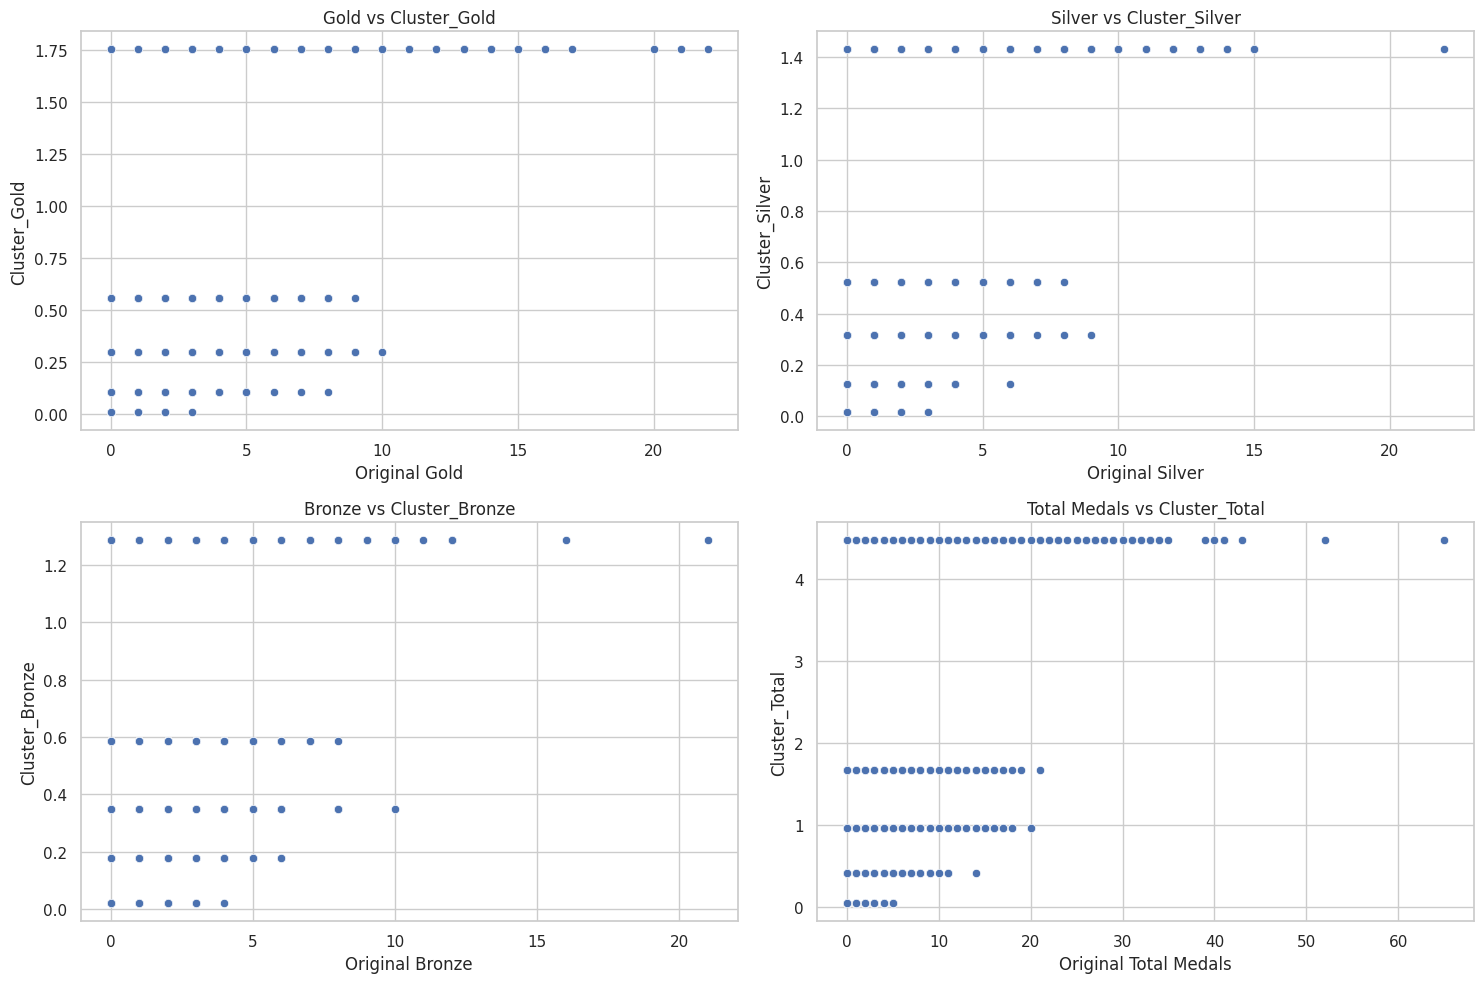

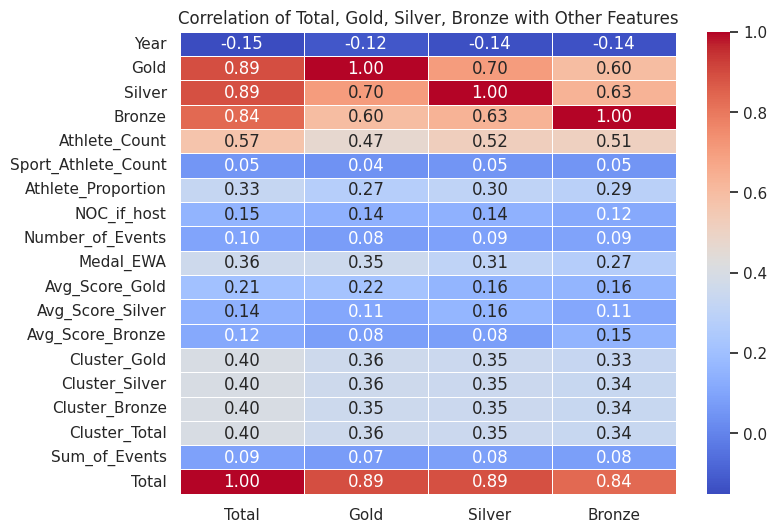

<Figure size 640x480 with 0 Axes>

In [23]:
train = replace_noc_with_kmeans(train, n_clusters=5)

plot_kmeans_comparison(train)
train = encode_sport_code_by_events(train)

calculate_and_plot_correlation(train)
plt.savefig("correlation_train.png", dpi=300, bbox_inches='tight')

**EDA**

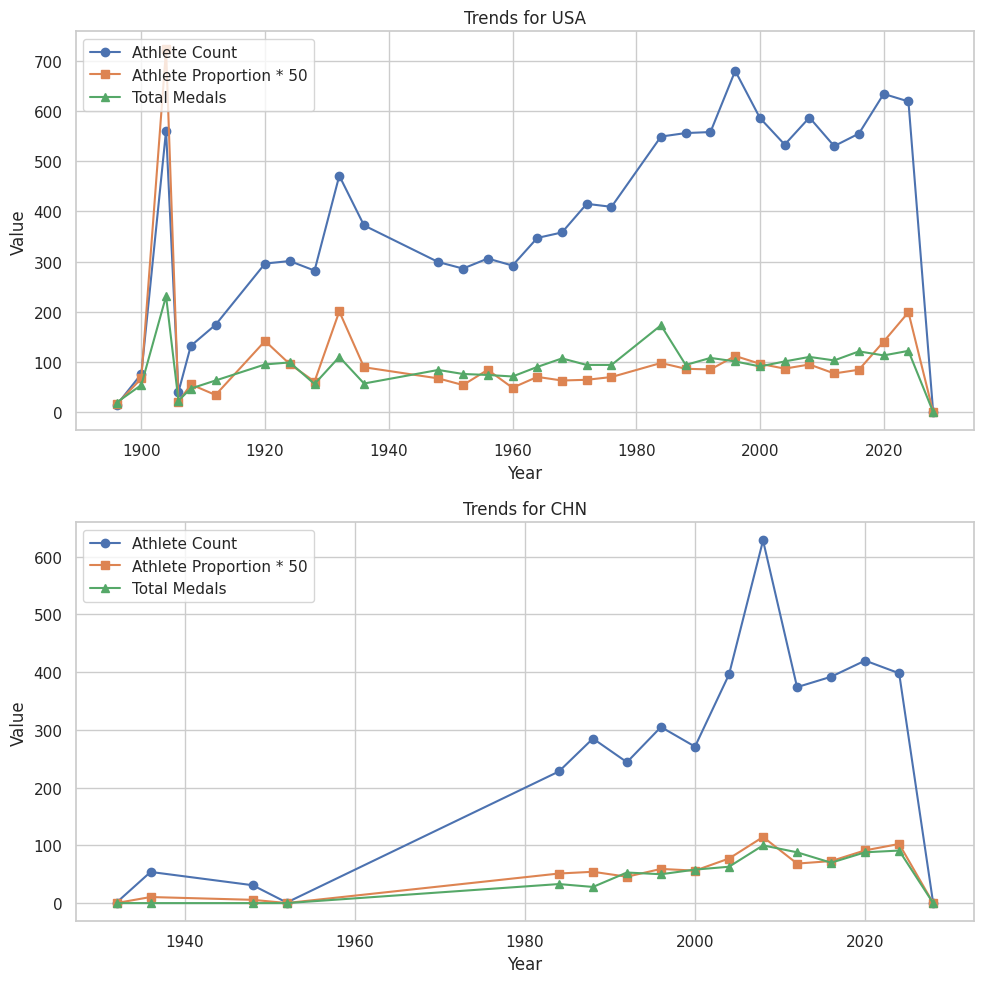

<Figure size 640x480 with 0 Axes>

In [24]:
athletes_effect = train.loc[:, ['Year', 'NOC', 'Gold', 'Silver','Bronze', 'Athlete_Count', 'Athlete_Proportion']].groupby(['Year', 'NOC']).sum().reset_index()
athletes_effect['Total_Medals'] = athletes_effect['Gold'] + athletes_effect['Silver'] + athletes_effect['Bronze']

selected_countries = ['USA', 'CHN']
filtered_data = athletes_effect[athletes_effect['NOC'].isin(selected_countries)]

fig, axes = plt.subplots(len(selected_countries), 1, figsize=(10, 5 * len(selected_countries)))

for i, country in enumerate(selected_countries):
    country_data = filtered_data[filtered_data['NOC'] == country]
    axes[i].plot(country_data['Year'], country_data['Athlete_Count'], label='Athlete Count', marker='o')
    axes[i].plot(country_data['Year'], country_data['Athlete_Proportion']*50, label='Athlete Proportion * 50', marker='s')
    axes[i].plot(country_data['Year'], country_data['Total_Medals'], label='Total Medals', marker='^')
    
    axes[i].set_title(f'Trends for {country}')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Value')
    axes[i].legend(loc='upper left')
    axes[i].grid(True)

plt.tight_layout()

plt.show()
plt.savefig("Correlation of (Athlete_Count and Athlete_Proportion) and Total_Medals.png", dpi=300, bbox_inches='tight')


In [25]:
average_data = athletes_effect.groupby('Year').agg({
    'Athlete_Count': 'mean',
    'Athlete_Proportion': 'mean',
    'Total_Medals': 'mean'
}).reset_index()

correlation_matrix = average_data[['Athlete_Count', 'Athlete_Proportion', 'Total_Medals']].corr()
print("Correlation matrix for averaged data:")
print(correlation_matrix)

mi = mutual_info_regression(average_data[['Athlete_Count', 'Athlete_Proportion']], average_data['Total_Medals'], random_state=0)
mi_results = dict(zip(average_data[['Athlete_Count', 'Athlete_Proportion']].columns, mi))

print("\nMutual Information for averaged data:")
for feature, value in mi_results.items():
    print(f"  {feature} -> Total_Medals: {value:.4f}")

Correlation matrix for averaged data:
                    Athlete_Count  Athlete_Proportion  Total_Medals
Athlete_Count            1.000000            0.288091      0.406542
Athlete_Proportion       0.288091            1.000000      0.965225
Total_Medals             0.406542            0.965225      1.000000

Mutual Information for averaged data:
  Athlete_Count -> Total_Medals: 0.4759
  Athlete_Proportion -> Total_Medals: 1.3620


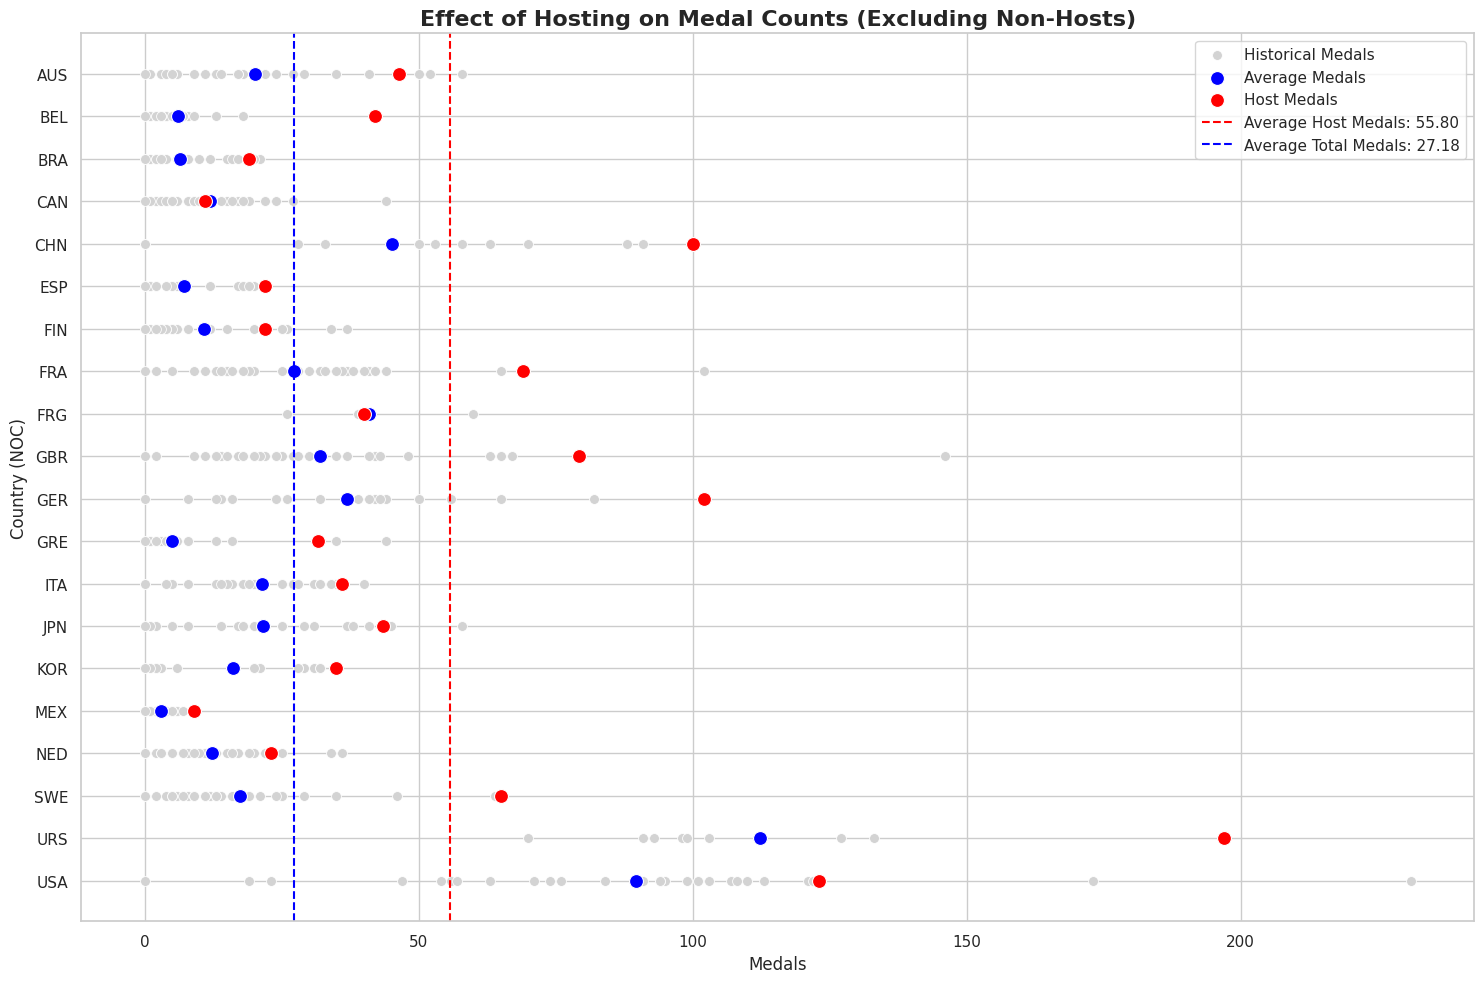

<Figure size 640x480 with 0 Axes>

In [26]:
# Prepare data for Host Effect EDA
train_eda = train.groupby(['Year', 'NOC'])[['Gold', 'Silver', 'Bronze']].sum().sort_values(by=['Year', 'Gold', 'Silver', 'Bronze'], ascending=[False, False, False, False]).reset_index()
train_eda = merge_hosts(train_eda, hosts)
train_eda

df_new = train_eda.copy()
df_new['Total_Medals'] = df_new[['Gold', 'Silver', 'Bronze']].sum(axis=1)

host_data = df_new[df_new['NOC_if_host'] == 1]
host_medals = host_data.groupby('NOC')['Total_Medals'].mean().reset_index()
host_medals.columns = ['NOC', 'Host_Medals']

country_avg_medals = df_new.groupby('NOC')[['Gold', 'Silver', 'Bronze']].mean().sum(axis=1).reset_index()
country_avg_medals.columns = ['NOC', 'Avg_Medals']

historical_medals = df_new.groupby(['NOC', 'Year'])['Total_Medals'].sum().reset_index()

final_data = country_avg_medals.merge(host_medals, on='NOC', how='left').fillna(0)
final_data = final_data.sort_values(by='Avg_Medals', ascending=False)
final_data = final_data[final_data['Host_Medals'] > 0]

# For each countries, Average Medal and Host Medal and all historical medals
plt.figure(figsize=(15, 10))
sns.scatterplot(
    data=historical_medals[historical_medals['NOC'].isin(final_data['NOC'])],
    x='Total_Medals',
    y='NOC',
    color='lightgray',
    s=50,
    label='Historical Medals',
)
sns.scatterplot(
    data=final_data,
    x='Avg_Medals',
    y='NOC',
    color='blue',
    s=100,
    label='Average Medals',
)
sns.scatterplot(
    data=final_data,
    x='Host_Medals',
    y='NOC',
    color='red',
    s=100,
    label='Host Medals',
)

avg_host_medals = final_data['Host_Medals'].mean()
avg_total_medals = final_data['Avg_Medals'].mean()

plt.axvline(avg_host_medals, color='red', linestyle='--', label=f'Average Host Medals: {avg_host_medals:.2f}')
plt.axvline(avg_total_medals, color='blue', linestyle='--', label=f'Average Total Medals: {avg_total_medals:.2f}')
plt.title('Effect of Hosting on Medal Counts (Excluding Non-Hosts)', fontsize=16, fontweight='bold')
plt.xlabel('Medals', fontsize=12)
plt.ylabel('Country (NOC)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("Effect of Hosting on Medal Counts (Excluding Non-Hosts).png", dpi=300, bbox_inches='tight')


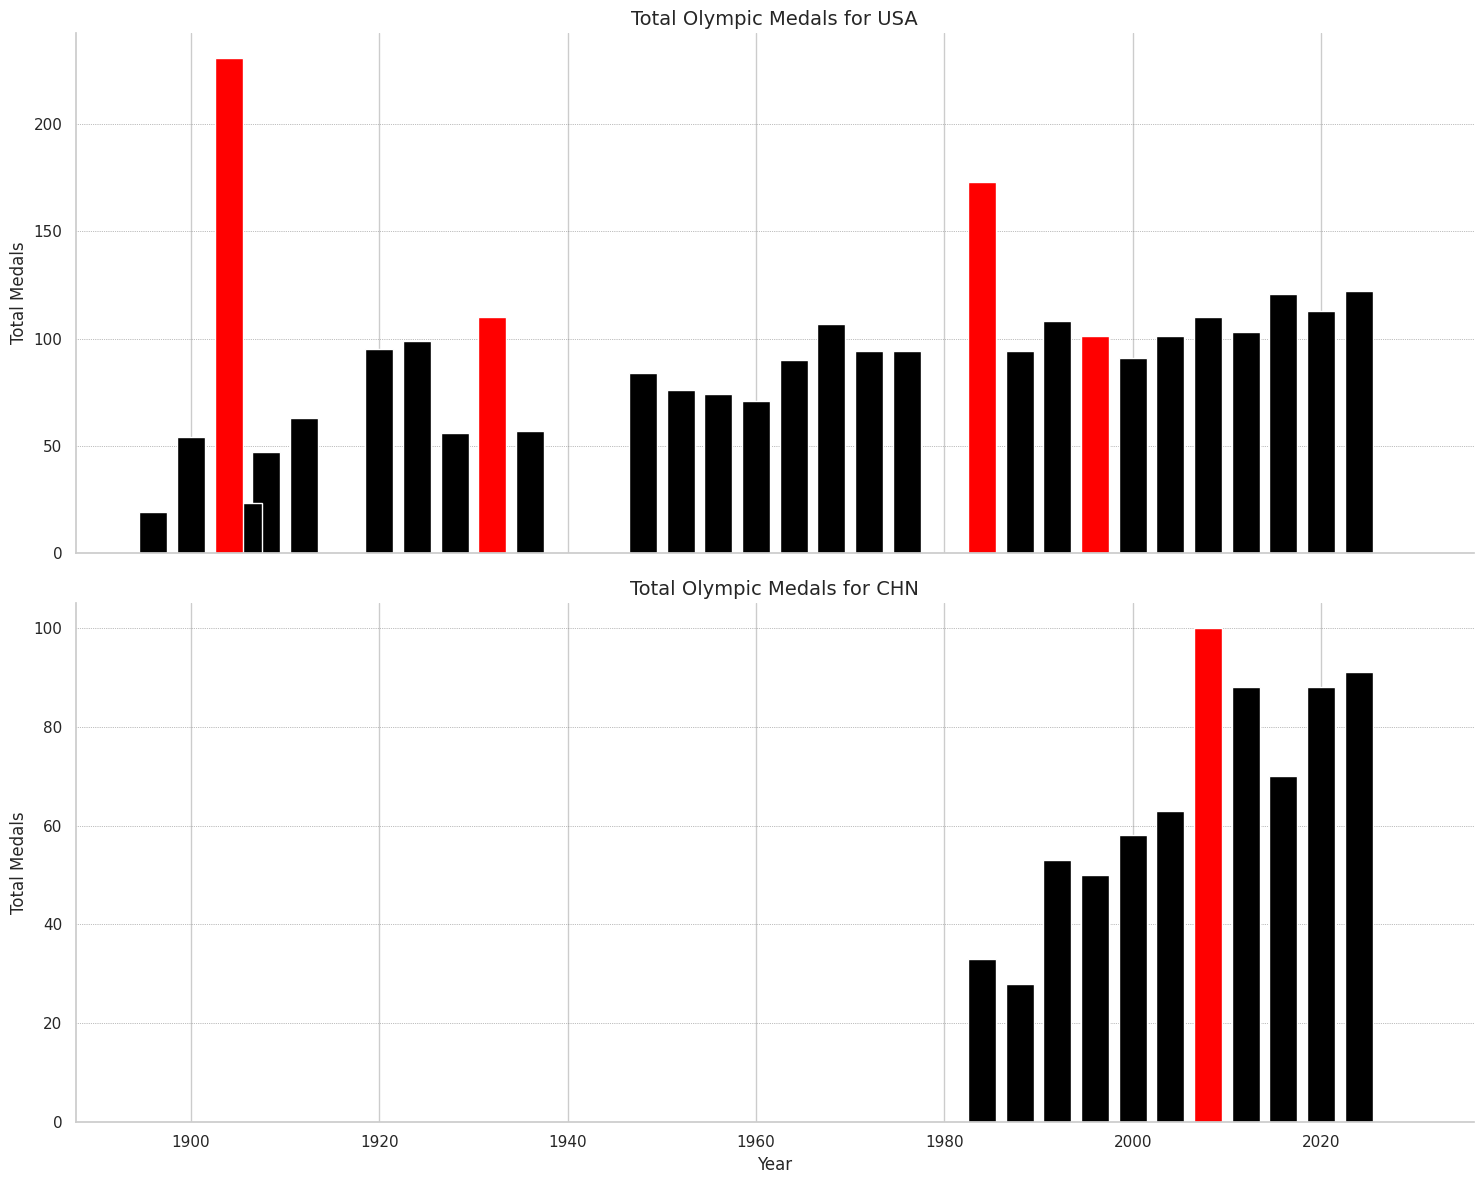

<Figure size 640x480 with 0 Axes>

In [27]:
# Total Medals for Countries Through Time
countries = ['USA', 'CHN']
filtered_data = df_new[df_new['NOC'].isin(countries)]

fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

for i, country in enumerate(countries):
    temp = filtered_data[filtered_data['NOC'] == country]
    color = ['red' if is_host == 1 else 'black' for is_host in temp['NOC_if_host']]

    axes[i].bar(temp['Year'], temp['Total_Medals'], width=3, color=color)
    axes[i].set_title(f'Total Olympic Medals for {country}', fontsize=14)
    axes[i].set_ylabel('Total Medals', fontsize=12)
    axes[i].grid(axis='y', linestyle=':', linewidth=0.5, color='gray')

    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

axes[-1].set_xlabel('Year', fontsize=12)
plt.tight_layout()
plt.show()
plt.savefig("Total Medals for Host and Not Host Years.png", dpi=300, bbox_inches='tight')


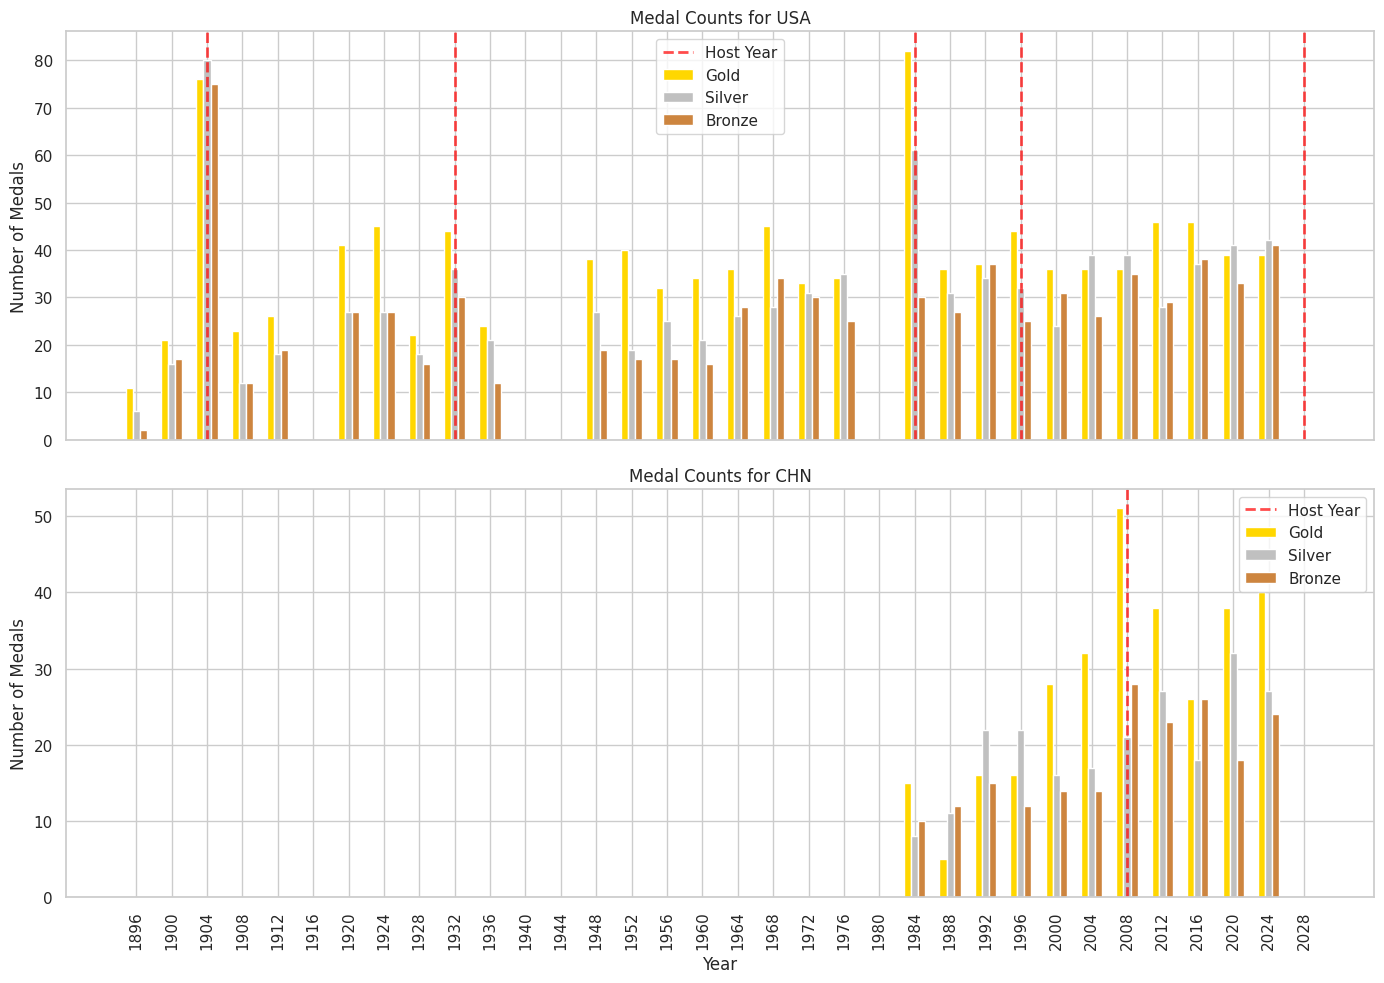

<Figure size 640x480 with 0 Axes>

In [28]:
# Gold, Silver, Bronze for countries in each year
medals_by_year = filtered_data.groupby(['Year', 'NOC'])[['Gold', 'Silver', 'Bronze']].sum().reset_index()

host_years = df_new[df_new['NOC_if_host'] == 1].groupby('NOC')['Year'].unique().reset_index()
host_years = {row['NOC']: row['Year'] for _, row in host_years.iterrows()}

all_years = np.arange(medals_by_year['Year'].min(), medals_by_year['Year'].max() + 1, 4)

fig, axes = plt.subplots(nrows=len(countries), ncols=1, figsize=(14, 10), sharex=True)
bar_width = 0.2

for i, country in enumerate(countries):
    country_data = medals_by_year[medals_by_year['NOC'] == country]
    country_data_full = pd.DataFrame({'Year': all_years})
    country_data_full = country_data_full.merge(country_data, on='Year', how='left').fillna(0)

    years = country_data_full['Year']
    gold = country_data_full['Gold']
    silver = country_data_full['Silver']
    bronze = country_data_full['Bronze']
    
    x = np.arange(len(years))
    
    axes[i].bar(x - bar_width, gold, width=bar_width, label='Gold', color='gold')
    axes[i].bar(x, silver, width=bar_width, label='Silver', color='silver')
    axes[i].bar(x + bar_width, bronze, width=bar_width, label='Bronze', color='peru')
    
    if country in host_years:
        for year in host_years[country]:
            if year in years.values:
                year_index = np.where(years == year)[0][0]
                axes[i].axvline(x=year_index, color='red', linestyle='--', linewidth=2, alpha=0.7, 
                                label='Host Year' if year == host_years[country][0] else "")
    
    axes[i].set_title(f'Medal Counts for {country}')
    axes[i].set_ylabel('Number of Medals')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(years, rotation=90)
    axes[i].legend()

axes[-1].set_xlabel('Year')
plt.tight_layout()
plt.show()
plt.savefig("Medals for Host and Not Host Years.png", dpi=300, bbox_inches='tight')


Key Statistics
Mean Natural Log of Total Medals when Not Hosting: 2.368
Mean Natural Log of Total Medals when Hosting: 3.781
Standard Error of Natural Log of Total Medals when Not Hosting: 0.059
Standard Error of Natural Log of Total Medals when Hosting: 0.186
Standard Errors between means: 7.253

T-Test
Statistics = -6.033, p-value = 0.000
Different distributions (reject H0)


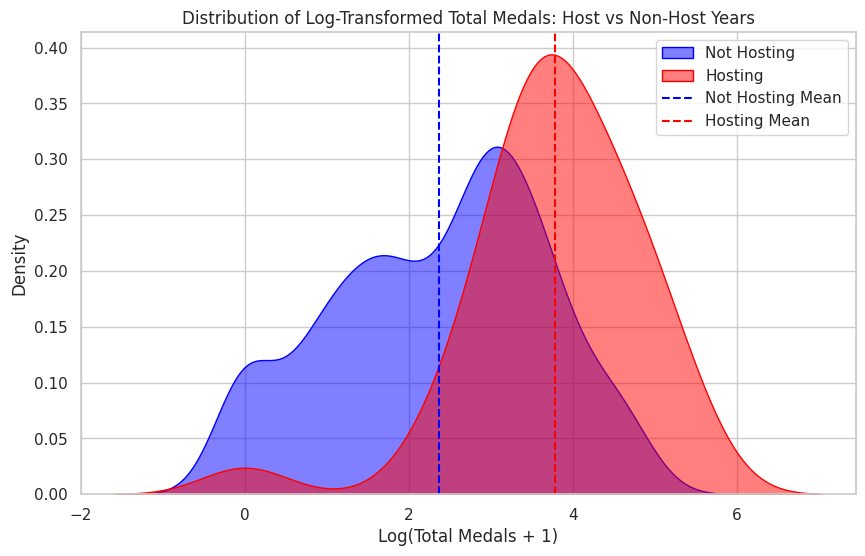

<Figure size 640x480 with 0 Axes>

In [29]:
# Statistic test
#To determine whether hosting the Olympics has a statistically significant effect on medal counts, we conducted a hypothesis test comparing the total medals won during host and non-host years. Since the total medals data is positively skewed, we applied a log transformation (using np.log1p) to make the distribution more normal, which is a key assumption for the t-test. We filtered the dataset to include only countries that have hosted the Olympics at least once, ensuring a fair comparison between host and non-host years for the same set of countries. The data was then split into two groups: host years (NOC_if_host == 1) and non-host years (NOC_if_host == 0). After applying the log transformation, we performed an independent two-sample t-test to compare the means of the log-transformed total medals between the two groups. The null hypothesis (H₀) was that the means are equal (no host effect), while the alternative hypothesis (H₁) was that the means are not equal (host effect exists). We calculated key statistics, including the means, standard errors, and the standardized difference between means. The t-test yielded a very small p-value (p < 0.05), leading us to reject the null hypothesis and conclude that there is a statistically significant difference in medal counts between host and non-host years. This suggests a host effect, where countries tend to win more medals when hosting the Olympics. The log transformation was crucial to ensure the validity of the t-test by addressing the skewness in the data.
df_new['Total_Medals'] = df_new[['Gold', 'Silver', 'Bronze']].sum(axis=1)

df_new['Total_Medals_NaturalLog'] = np.log1p(df_new['Total_Medals'])  # log(1 + x) to handle zeros

host_countries = df_new[df_new['NOC_if_host'] == 1]['NOC'].unique()
df_filtered = df_new[df_new['NOC'].isin(host_countries)]

host_data = df_filtered[df_filtered['NOC_if_host'] == 1]
non_host_data = df_filtered[df_filtered['NOC_if_host'] == 0]

not_hosting_mean = non_host_data['Total_Medals_NaturalLog'].mean()
hosting_mean = host_data['Total_Medals_NaturalLog'].mean()

not_hosting_std = non_host_data['Total_Medals_NaturalLog'].std()
hosting_std = host_data['Total_Medals_NaturalLog'].std()

not_hosting_samples = non_host_data['Total_Medals_NaturalLog'].count()
hosting_samples = host_data['Total_Medals_NaturalLog'].count()

not_hosting_std_error = not_hosting_std / np.sqrt(not_hosting_samples)
hosting_std_error = hosting_std / np.sqrt(hosting_samples)

difference = hosting_mean - not_hosting_mean
combined_std_error = np.sqrt((not_hosting_std**2 / not_hosting_samples) + (hosting_std**2 / hosting_samples))

stat, p = ttest_ind(non_host_data['Total_Medals_NaturalLog'], host_data['Total_Medals_NaturalLog'])

print("Key Statistics")
print(f"Mean Natural Log of Total Medals when Not Hosting: {not_hosting_mean:.3f}")
print(f"Mean Natural Log of Total Medals when Hosting: {hosting_mean:.3f}")
print(f"Standard Error of Natural Log of Total Medals when Not Hosting: {not_hosting_std_error:.3f}")
print(f"Standard Error of Natural Log of Total Medals when Hosting: {hosting_std_error:.3f}")
print(f"Standard Errors between means: {difference / combined_std_error:.3f}")

print("\nT-Test")
print(f"Statistics = {stat:.3f}, p-value = {p:.3f}")
if p < 0.05:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")

plt.figure(figsize=(10, 6))
sns.kdeplot(non_host_data['Total_Medals_NaturalLog'], label='Not Hosting', color='blue', shade=True, alpha=0.5)
sns.kdeplot(host_data['Total_Medals_NaturalLog'], label='Hosting', color='red', shade=True, alpha=0.5)
plt.axvline(not_hosting_mean, color='blue', linestyle='--', label='Not Hosting Mean')
plt.axvline(hosting_mean, color='red', linestyle='--', label='Hosting Mean')
plt.title('Distribution of Log-Transformed Total Medals: Host vs Non-Host Years')
plt.xlabel('Log(Total Medals + 1)')
plt.ylabel('Density')
plt.legend()
plt.show()
plt.savefig("Distribution of Total Medals When Hosting and Not Hosting.png", dpi=300, bbox_inches='tight')

**Time Series Features and Features Selection**

Correlation matrix for shifted data:
                         Prev_Athlete_Count  Prev_Athlete_Proportion  \
Prev_Athlete_Count                 1.000000                 0.779721   
Prev_Athlete_Proportion            0.779721                 1.000000   
Total_Medals                       0.697481                 0.502211   

                         Total_Medals  
Prev_Athlete_Count           0.697481  
Prev_Athlete_Proportion      0.502211  
Total_Medals                 1.000000  

Mutual Information for shifted data:
  Prev_Athlete_Count -> Total_Medals: 0.4431
  Prev_Athlete_Proportion -> Total_Medals: 0.4607


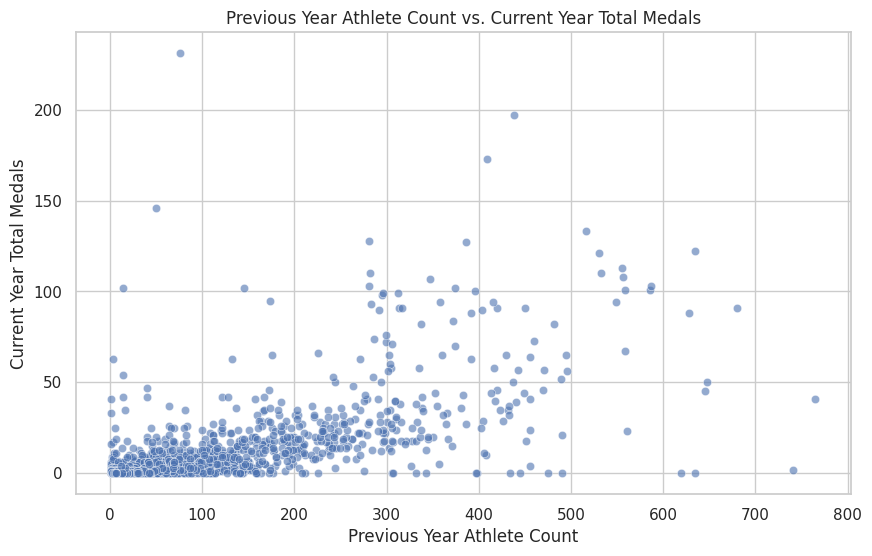

<Figure size 640x480 with 0 Axes>

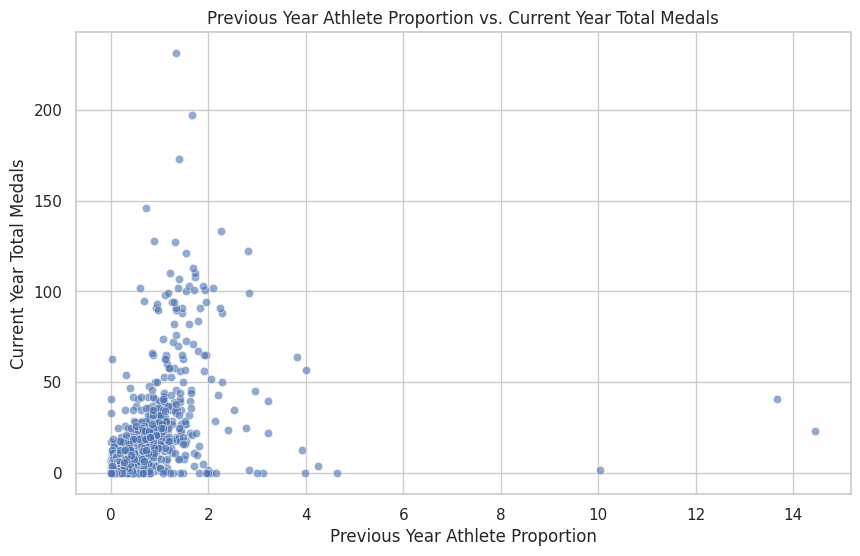

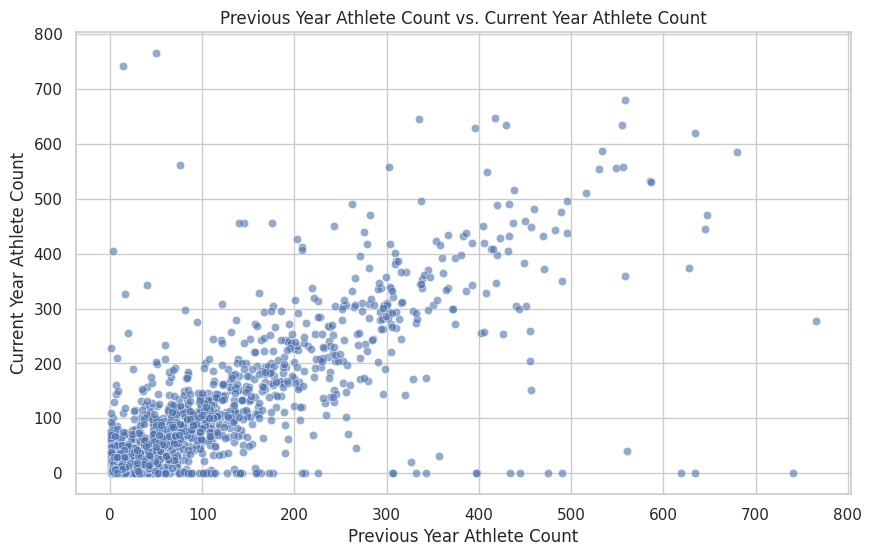

<Figure size 640x480 with 0 Axes>

In [30]:
athletes_effect = train.loc[:, ['Year', 'NOC', 'Gold', 'Silver','Bronze', 'Athlete_Count', 'Athlete_Proportion']].groupby(['Year', 'NOC']).sum().reset_index()
athletes_effect['Total_Medals'] = athletes_effect['Gold'] + athletes_effect['Silver'] + athletes_effect['Bronze']

grouped_data = athletes_effect.groupby(['NOC']).apply(
    lambda x: x.sort_values('Year')
).reset_index(drop=True)

# Shift Athlete_Count and Athlete_Proportion to get previous year's values
grouped_data['Prev_Athlete_Count'] = grouped_data.groupby(['NOC'])['Athlete_Count'].shift(1)
grouped_data['Prev_Athlete_Proportion'] = grouped_data.groupby(['NOC'])['Athlete_Proportion'].shift(1)

# Drop rows with NaN values (due to shifting)
grouped_data = grouped_data.dropna()

# Calculate correlation matrix for shifted data
correlation_matrix = grouped_data[['Prev_Athlete_Count', 'Prev_Athlete_Proportion', 'Total_Medals']].corr()
print("Correlation matrix for shifted data:")
print(correlation_matrix)


# Calculate mutual information
mi = mutual_info_regression(grouped_data[['Prev_Athlete_Count', 'Prev_Athlete_Proportion']], grouped_data['Total_Medals'], random_state=0)
mi_results = dict(zip(grouped_data[['Prev_Athlete_Count', 'Prev_Athlete_Proportion']].columns, mi))

print("\nMutual Information for shifted data:")
for feature, value in mi_results.items():
    print(f"  {feature} -> Total_Medals: {value:.4f}")


sns.set(style="whitegrid")

# Scatter plot: Prev_Athlete_Count vs. Total_Medals
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Prev_Athlete_Count', y='Total_Medals', data=grouped_data, alpha=0.6)
plt.title('Previous Year Athlete Count vs. Current Year Total Medals')
plt.xlabel('Previous Year Athlete Count')
plt.ylabel('Current Year Total Medals')
plt.show()
plt.savefig("Previous Year Athlete Count vs. Current Year Total Medals.png", dpi=300, bbox_inches='tight')


plt.figure(figsize=(10, 6))
sns.scatterplot(x='Prev_Athlete_Proportion', y='Total_Medals', data=grouped_data, alpha=0.6)
plt.title('Previous Year Athlete Proportion vs. Current Year Total Medals')
plt.xlabel('Previous Year Athlete Proportion')
plt.ylabel('Current Year Total Medals')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Prev_Athlete_Count', y='Athlete_Count', data=grouped_data, alpha=0.6)
plt.title('Previous Year Athlete Count vs. Current Year Athlete Count')
plt.xlabel('Previous Year Athlete Count')
plt.ylabel('Current Year Athlete Count')
plt.show()
plt.savefig("Previous Year Athlete Count vs. Current Year Athlete Count.png", dpi=300, bbox_inches='tight')


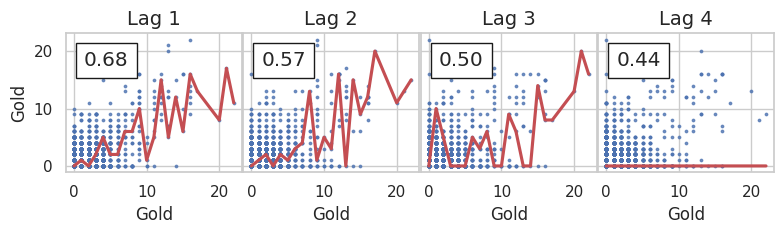

<Figure size 640x480 with 0 Axes>

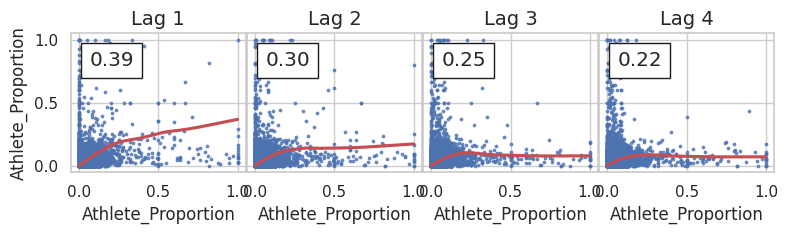

<Figure size 640x480 with 0 Axes>

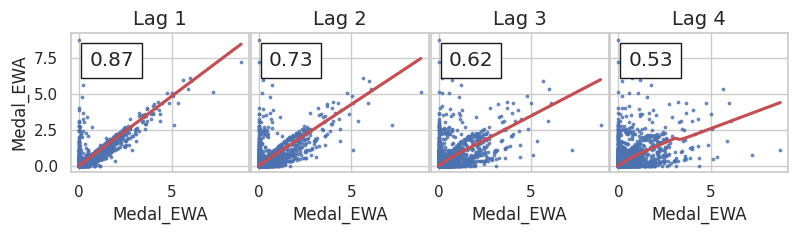

<Figure size 640x480 with 0 Axes>

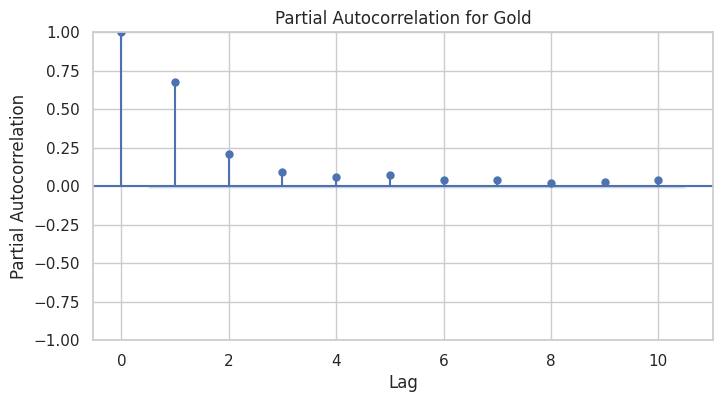

<Figure size 640x480 with 0 Axes>

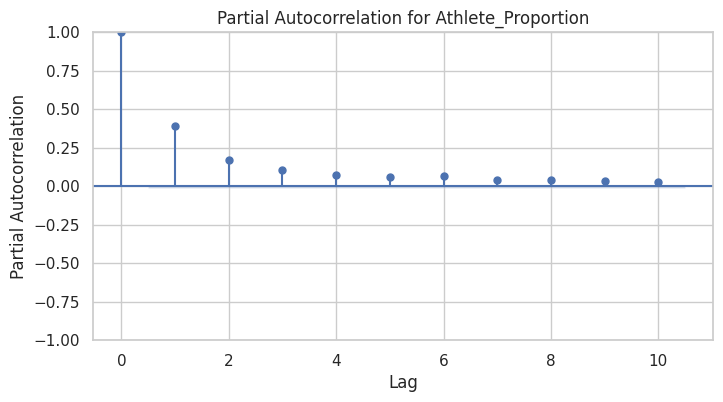

<Figure size 640x480 with 0 Axes>

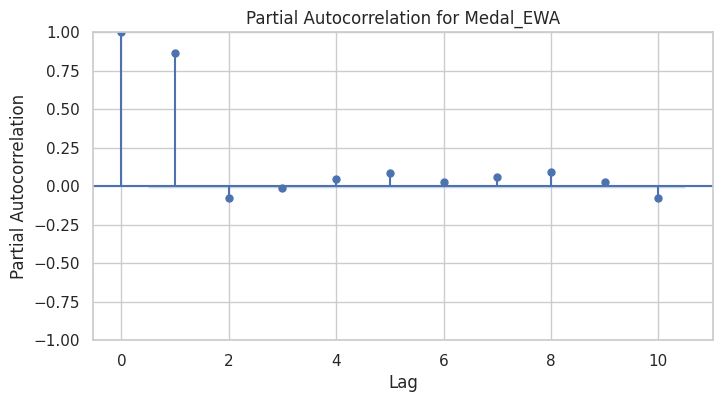

<Figure size 640x480 with 0 Axes>

In [31]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    """
    Plot the relationship between a feature and its lagged version.
    """
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(alpha=0.75, s=3)
    line_kws = dict(color='C3')
    ax = sns.regplot(x=x_, y=y_, scatter_kws=scatter_kws, line_kws=line_kws, lowess=True, ax=ax, **kwargs)
    at = AnchoredText(f"{corr:.2f}", prop=dict(size="large"), frameon=True, loc="upper left")
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax
    
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    """
    Plot multiple lag plots for a feature.
    """
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


def create_lagged_features_safely(train, features_to_lag, max_lag=2):
    X = train.copy()

    X = X.sort_values(by=['NOC', 'Sport_Code', 'Year'])

    for feature in features_to_lag:
        for lag in range(1, max_lag + 1):
            lagged_series = X.groupby(['NOC', 'Sport_Code'])[feature].shift(lag)
            lagged_series = lagged_series.groupby([X['NOC'], X['Sport_Code']]).ffill().bfill().fillna(0)
            X[f'{feature}_lag{lag}'] = lagged_series

    return X

def plot_partial_autocorrelation(series, lags=10):
    """
    Plot the partial autocorrelation function (PACF) for a time series.
    """
    fig, ax = plt.subplots(figsize=(8, 4))
    plot_pacf(series, lags=lags, ax=ax, method='ywm')
    plt.title(f'Partial Autocorrelation for {series.name}')
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.show()


features_to_lag = ['Athlete_Count', 'Athlete_Proportion', 'Medal_EWA', 'Avg_Score_Gold', 'Avg_Score_Silver', 'Avg_Score_Bronze', 'Gold', 'Silver', 'Bronze']
X_original = create_lagged_features_safely(train, features_to_lag, max_lag=2)

plot_lags(X_original['Gold'], lags=4, nrows=1)
plt.show()
plt.savefig("plot_lags_Gold.png", dpi=300, bbox_inches='tight')

plot_lags(X_original['Athlete_Proportion'], lags=4, nrows=1)
plt.show()
plt.savefig("plot_lags_Athlete_Proportion.png", dpi=300, bbox_inches='tight')

plot_lags(X_original['Medal_EWA'], lags=4, nrows=1)
plt.show()
plt.savefig("plot_lags_Medal_EWA.png", dpi=300, bbox_inches='tight')

plot_partial_autocorrelation(X_original['Gold'], lags=10)
plt.savefig("partial_autocorrelation_Gold.png", dpi=300, bbox_inches='tight')
plot_partial_autocorrelation(X_original['Athlete_Proportion'], lags=10)
plt.savefig("partial_autocorrelation_Athlete_Proportion.png", dpi=300, bbox_inches='tight')
plot_partial_autocorrelation(X_original['Medal_EWA'], lags=10)
plt.savefig("partial_autocorrelation_Medal_EWA.png", dpi=300, bbox_inches='tight')



In [32]:
X_original = X_original[['Year', 'NOC', 'Sport_Code', 'Gold', 'Silver', 'Bronze', 'NOC_if_host',
       'Number_of_Events', 'Cluster_Gold',
       'Cluster_Silver', 'Cluster_Bronze', 'Cluster_Total', 'Sum_of_Events',
       'Athlete_Count_lag1', 'Athlete_Count_lag2', 'Athlete_Proportion_lag1',
       'Athlete_Proportion_lag2', 'Medal_EWA_lag1','Avg_Score_Gold_lag1', 
       'Avg_Score_Silver_lag1', 'Avg_Score_Bronze_lag1', 
       'Gold_lag1', 'Gold_lag2', 'Silver_lag1', 'Silver_lag2', 'Bronze_lag1',
       'Bronze_lag2']]
X_original = X_original.sort_values(by=['Year', 'Gold', 'Silver', 'Bronze'], ascending=[False, False, False, False])


In [33]:
X

,Gold,Silver,Bronze,NOC_if_host,Number_of_Events,Cluster_Gold,Cluster_Silver,Cluster_Bronze,Cluster_Total,Sum_of_Events,...,Medal_EWA_lag1,Avg_Score_Gold_lag1,Avg_Score_Silver_lag1,Avg_Score_Bronze_lag1,Gold_lag1,Gold_lag2,Silver_lag1,Silver_lag2,Bronze_lag1,Bronze_lag2
3454,14,11,9,0,48,1.753481,1.430056,1.286129,4.469667,122959,...,0.302159,1.299983,1.068477,0.885619,7.0,13.0,12.0,10.0,7.0,9.0
3455,8,12,7,0,35,1.753481,1.430056,1.286129,4.469667,59528,...,0.354801,1.299983,1.068477,0.885619,11.0,16.0,10.0,8.0,9.0,9.0
3456,8,2,1,0,8,0.560640,0.522417,0.585553,1.668610,3429,...,0.802596,1.127080,1.104706,0.989321,7.0,7.0,5.0,2.0,0.0,1.0
3457,8,1,2,0,6,0.298198,0.317325,0.350194,0.965716,9451,...,0.918336,0.488205,0.161392,0.108728,5.0,4.0,1.0,3.0,1.0,0.0
3458,7,8,3,0,35,0.298198,0.317325,0.350194,0.965716,59528,...,0.251106,0.648215,0.708818,0.818245,9.0,3.0,3.0,4.0,8.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29920,0,0,0,0,5,0.298198,0.317325,0.350194,0.965716,19653,...,0.054049,0.683876,0.683876,0.683876,0.0,0.0,0.0,0.0,0.0,0.0
29921,0,0,0,0,5,0.108478,0.125539,0.178827,0.412844,19653,...,0.118944,0.683876,2.279586,0.683876,0.0,0.0,0.0,0.0,0.0,0.0
29922,0,0,0,0,12,0.298198,0.317325,0.350194,0.965716,122959,...,0.058845,0.683876,0.683876,0.683876,0.0,0.0,0.0,0.0,0.0,0.0
29923,0,0,0,0,8,0.298198,0.317325,0.350194,0.965716,10371,...,0.078995,0.683876,0.683876,0.683876,0.0,0.0,0.0,0.0,0.0,0.0


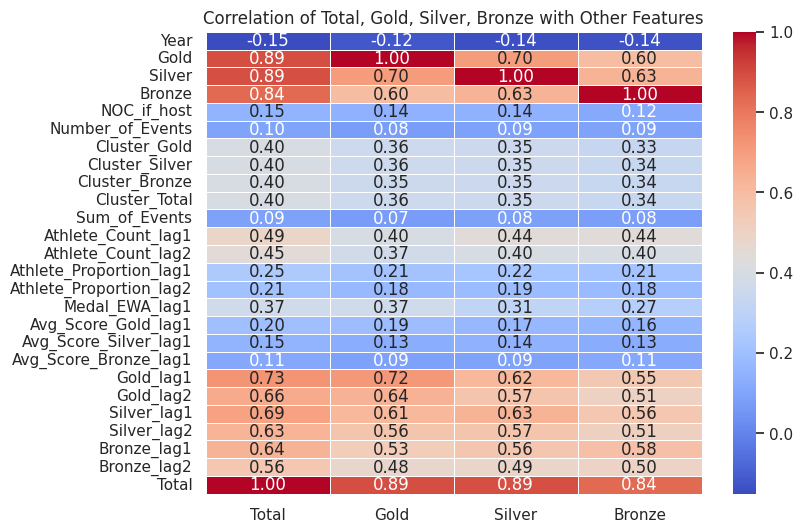

In [34]:
calculate_and_plot_correlation(X_original)
X_original = X_original.drop(['Total'], axis=1)

In [35]:
test = X_original[X_original['Year']==2028].copy()
test_vis = test.copy()
test = test.drop(['Year', 'NOC', 'Sport_Code'], axis=1)
X = X_original[X_original['Year']!=2028].copy()
vis = X.copy()
X = X.drop(['Year', 'NOC', 'Sport_Code'], axis=1)

In [36]:
def random_search_hyperparameters():
    return {
        'n_layers': random.choice([2, 3, 4]),
        'neurons': random.choice([64, 128, 256]),
        'dropout_rate': random.uniform(0.1, 0.4),
        'learning_rate': random.uniform(0.0001, 0.01)
    }

def build_model(input_dim, n_layers, neurons, dropout_rate, learning_rate):
    inputs = Input(shape=(input_dim,))
    x = Dense(neurons, activation='relu')(inputs)
    for _ in range(n_layers - 1):
        residual = x
        x = Dense(neurons, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
        x = Add()([x, residual])
    x = Dense(32, activation='relu')(x)
    outputs = Dense(3, activation='linear')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
    return model

def random_search(X_train, y_train, X_val, y_val):
    best_r2 = -np.inf
    best_params = None
    best_model = None

    for _ in range(10):
        params = random_search_hyperparameters()
        model = build_model(
            input_dim=X_train.shape[1],
            n_layers=params['n_layers'],
            neurons=params['neurons'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )

        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            verbose=0,
            callbacks=[early_stop]
        )

        y_pred = model.predict(X_val)
        r2_gold = r2_score(y_val['Gold'], y_pred[:, 0])
        r2_silver = r2_score(y_val['Silver'], y_pred[:, 1])
        r2_bronze = r2_score(y_val['Bronze'], y_pred[:, 2])
        avg_r2 = (r2_gold + r2_silver + r2_bronze) / 3

        if avg_r2 > best_r2:
            best_r2 = avg_r2
            best_params = params
            best_model = model

    return best_model, best_params, best_r2

X_train, X_val, y_train, y_val = train_test_split(
    X.drop(columns=['Gold', 'Silver', 'Bronze']),
    X[['Gold', 'Silver', 'Bronze']],
    test_size=0.2,
    random_state=42
)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)

#model, best_params, best_r2 = random_search(X_train, y_train, X_val, y_val)
best_params = {'n_layers': 4,
  'neurons': 64,
  'dropout_rate': 0.10750322656680009,
  'learning_rate': 0.002822790251854281} # R2 is 0.7682101986647364

model = build_model(
    input_dim=X_train.shape[1],
    n_layers=best_params['n_layers'],
    neurons=best_params['neurons'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

y_pred_final = model.predict(X_val)
r2_gold_final = r2_score(y_val['Gold'], y_pred_final[:, 0])
r2_silver_final = r2_score(y_val['Silver'], y_pred_final[:, 1])
r2_bronze_final = r2_score(y_val['Bronze'], y_pred_final[:, 2])

print(f"Final R² for Gold: {r2_gold_final:.4f}")
print(f"Final R² for Silver: {r2_silver_final:.4f}")
print(f"Final R² for Bronze: {r2_bronze_final:.4f}")


Epoch 1/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9252 - mae: 0.5432 - val_loss: 0.3088 - val_mae: 0.2596
Epoch 2/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3673 - mae: 0.2827 - val_loss: 0.2879 - val_mae: 0.2424
Epoch 3/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3405 - mae: 0.2573 - val_loss: 0.2817 - val_mae: 0.2301
Epoch 4/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3304 - mae: 0.2504 - val_loss: 0.2787 - val_mae: 0.2293
Epoch 5/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3272 - mae: 0.2495 - val_loss: 0.2814 - val_mae: 0.2291
Epoch 6/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3259 - mae: 0.2521 - val_loss: 0.2752 - val_mae: 0.2332
Epoch 7/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3125 - mae: 0.2485 - val_loss: 0.2762 - val_mae: 0.2282
Epoch 8/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3088 - mae: 0.2479 - val_loss: 0.2709 - val_mae: 0.2257
Epoch 9/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/

In [37]:
y_pred_all_scaled = model.predict(scaler_X.transform(X.drop(['Gold', 'Silver', 'Bronze'], axis=1)))
y_pred_all = scaler_y.inverse_transform(y_pred_all_scaled)
vis['Predicted_Gold'] = y_pred_all[:, 0]
vis['Predicted_Silver'] = y_pred_all[:, 1]
vis['Predicted_Bronze'] = y_pred_all[:, 2]

vis = vis[['Year', 'NOC', 'Sport_Code', 'Gold', 'Silver', 'Bronze', 'Predicted_Gold', 'Predicted_Silver', 'Predicted_Bronze']]

r2_gold_lag = r2_score(X['Gold_lag1'], X['Gold'])
r2_silver_lag = r2_score(X['Silver_lag1'], X['Silver'])
r2_bronze_lag = r2_score(X['Bronze_lag1'], X['Bronze'])
r2_total_lag = r2_score(
    X[['Gold_lag1', 'Silver_lag1', 'Bronze_lag1']].sum(axis=1),
    X[['Gold', 'Silver', 'Bronze']].sum(axis=1)
)
print(f"R² for Gold (Lagged Values): {r2_gold_lag:.4f}")
print(f"R² for Silver (Lagged Values): {r2_silver_lag:.4f}")
print(f"R² for Bronze (Lagged Values): {r2_bronze_lag:.4f}")
print(f"R² for Total Medals (Lagged Values): {r2_total_lag:.4f}\n")

r2_gold_sport = r2_score(vis['Gold'], vis['Predicted_Gold'])
r2_silver_sport = r2_score(vis['Silver'], vis['Predicted_Silver'])
r2_bronze_sport = r2_score(vis['Bronze'], vis['Predicted_Bronze'])
r2_total_sport = r2_score(
    vis[['Gold', 'Silver', 'Bronze']].sum(axis=1),
    vis[['Predicted_Gold', 'Predicted_Silver', 'Predicted_Bronze']].sum(axis=1)
)
print(f"R² for Gold (Year, NOC, Sport_Code): {r2_gold_sport:.4f}")
print(f"R² for Silver (Year, NOC, Sport_Code): {r2_silver_sport:.4f}")
print(f"R² for Bronze (Year, NOC, Sport_Code): {r2_bronze_sport:.4f}")
print(f"R² for Total Medals (Year, NOC, Sport_Code): {r2_total_sport:.4f}\n")

aggregated_vis = vis.groupby(['Year', 'NOC']).sum().reset_index()
r2_gold = r2_score(aggregated_vis['Gold'], aggregated_vis['Predicted_Gold'])
r2_silver = r2_score(aggregated_vis['Silver'], aggregated_vis['Predicted_Silver'])
r2_bronze = r2_score(aggregated_vis['Bronze'], aggregated_vis['Predicted_Bronze'])
r2_total_year_noc = r2_score(
    aggregated_vis[['Gold', 'Silver', 'Bronze']].sum(axis=1),
    aggregated_vis[['Predicted_Gold', 'Predicted_Silver', 'Predicted_Bronze']].sum(axis=1)
)
print(f"R² for Gold (Year, NOC): {r2_gold:.4f}")
print(f"R² for Silver (Year, NOC): {r2_silver:.4f}")
print(f"R² for Bronze (Year, NOC): {r2_bronze:.4f}")
print(f"R² for Total Medals (Year, NOC): {r2_total_year_noc:.4f}")

828/828 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
R² for Gold (Lagged Values): 0.4520
R² for Silver (Lagged Values): 0.2885
R² for Bronze (Lagged Values): 0.1812
R² for Total Medals (Lagged Values): 0.6036

R² for Gold (Year, NOC, Sport_Code): 0.6157
R² for Silver (Year, NOC, Sport_Code): 0.5180
R² for Bronze (Year, NOC, Sport_Code): 0.4362
R² for Total Medals (Year, NOC, Sport_Code): 0.6795

R² for Gold (Year, NOC): 0.7327
R² for Silver (Year, NOC): 0.7650
R² for Bronze (Year, NOC): 0.7504
R² for Total Medals (Year, NOC): 0.7929


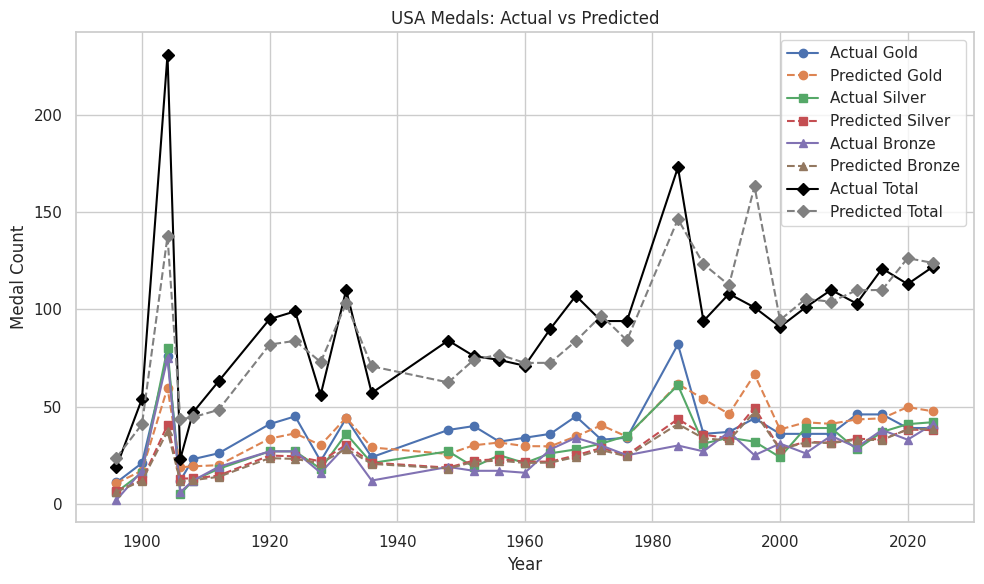

In [65]:
usa_data = aggregated_vis[aggregated_vis['NOC'] == 'USA']
usa_data['Total'] = usa_data[['Gold', 'Silver', 'Bronze']].sum(axis=1)
usa_data['Predicted_Total'] = usa_data[['Predicted_Gold', 'Predicted_Silver', 'Predicted_Bronze']].sum(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(usa_data['Year'], usa_data['Gold'], label='Actual Gold', marker='o')
plt.plot(usa_data['Year'], usa_data['Predicted_Gold'], label='Predicted Gold', marker='o', linestyle='--')

plt.plot(usa_data['Year'], usa_data['Silver'], label='Actual Silver', marker='s')
plt.plot(usa_data['Year'], usa_data['Predicted_Silver'], label='Predicted Silver', marker='s', linestyle='--')

plt.plot(usa_data['Year'], usa_data['Bronze'], label='Actual Bronze', marker='^')
plt.plot(usa_data['Year'], usa_data['Predicted_Bronze'], label='Predicted Bronze', marker='^', linestyle='--')

plt.plot(usa_data['Year'], usa_data['Total'], label='Actual Total', marker='D', color='black')
plt.plot(usa_data['Year'], usa_data['Predicted_Total'], label='Predicted Total', marker='D', linestyle='--', color='gray')

plt.title('USA Medals: Actual vs Predicted')
plt.xlabel('Year')
plt.ylabel('Medal Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


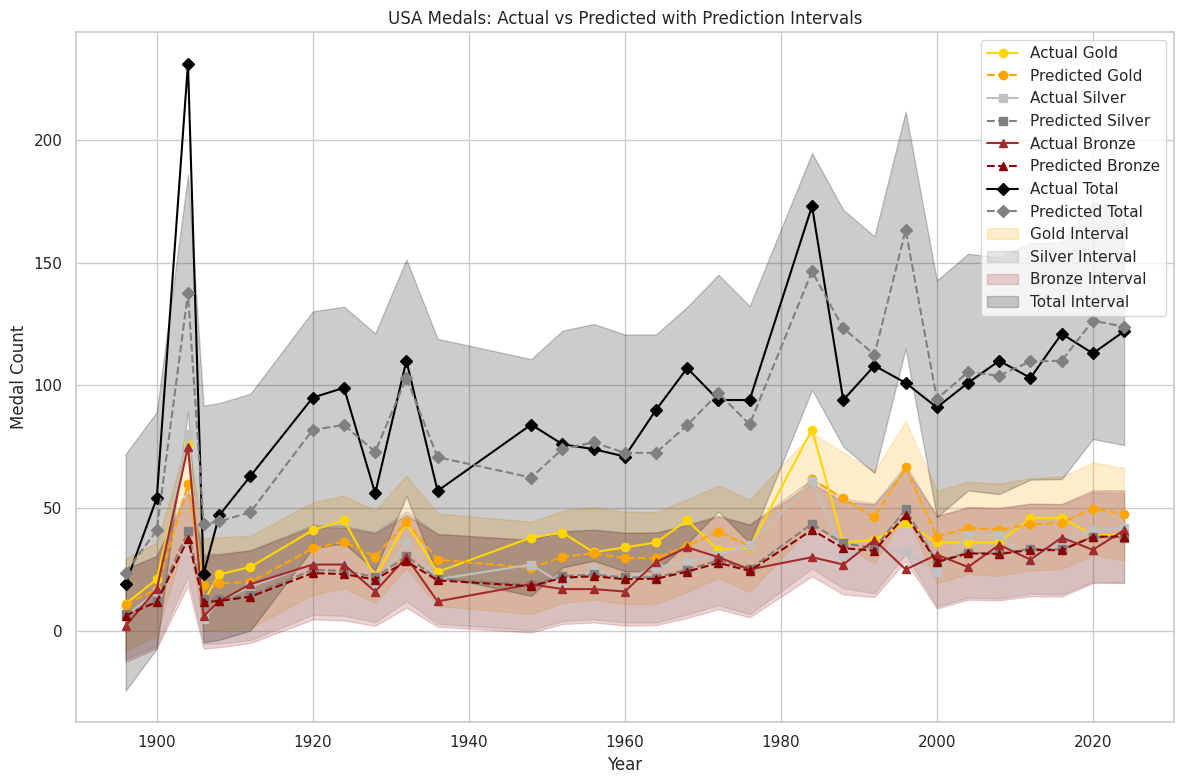

In [66]:
usa_data['Residual_Gold'] = usa_data['Gold'] - usa_data['Predicted_Gold']
usa_data['Residual_Silver'] = usa_data['Silver'] - usa_data['Predicted_Silver']
usa_data['Residual_Bronze'] = usa_data['Bronze'] - usa_data['Predicted_Bronze']
usa_data['Residual_Total'] = usa_data['Total'] - usa_data['Predicted_Total']

std_gold = usa_data['Residual_Gold'].std()
std_silver = usa_data['Residual_Silver'].std()
std_bronze = usa_data['Residual_Bronze'].std()
std_total = usa_data['Residual_Total'].std()

confidence_factor = 1.96  # For 95% confidence interval
usa_data['Gold_Lower'] = usa_data['Predicted_Gold'] - confidence_factor * std_gold
usa_data['Gold_Upper'] = usa_data['Predicted_Gold'] + confidence_factor * std_gold

usa_data['Silver_Lower'] = usa_data['Predicted_Silver'] - confidence_factor * std_silver
usa_data['Silver_Upper'] = usa_data['Predicted_Silver'] + confidence_factor * std_silver

usa_data['Bronze_Lower'] = usa_data['Predicted_Bronze'] - confidence_factor * std_bronze
usa_data['Bronze_Upper'] = usa_data['Predicted_Bronze'] + confidence_factor * std_bronze

usa_data['Total_Lower'] = usa_data['Predicted_Total'] - confidence_factor * std_total
usa_data['Total_Upper'] = usa_data['Predicted_Total'] + confidence_factor * std_total

plt.figure(figsize=(12, 8))

plt.plot(usa_data['Year'], usa_data['Gold'], label='Actual Gold', marker='o', color='gold')
plt.plot(usa_data['Year'], usa_data['Predicted_Gold'], label='Predicted Gold', marker='o', linestyle='--', color='orange')

plt.plot(usa_data['Year'], usa_data['Silver'], label='Actual Silver', marker='s', color='silver')
plt.plot(usa_data['Year'], usa_data['Predicted_Silver'], label='Predicted Silver', marker='s', linestyle='--', color='gray')

plt.plot(usa_data['Year'], usa_data['Bronze'], label='Actual Bronze', marker='^', color='brown')
plt.plot(usa_data['Year'], usa_data['Predicted_Bronze'], label='Predicted Bronze', marker='^', linestyle='--', color='darkred')

plt.plot(usa_data['Year'], usa_data['Total'], label='Actual Total', marker='D', color='black')
plt.plot(usa_data['Year'], usa_data['Predicted_Total'], label='Predicted Total', marker='D', linestyle='--', color='gray')

plt.fill_between(usa_data['Year'], usa_data['Gold_Lower'], usa_data['Gold_Upper'], color='orange', alpha=0.2, label='Gold Interval')
plt.fill_between(usa_data['Year'], usa_data['Silver_Lower'], usa_data['Silver_Upper'], color='gray', alpha=0.2, label='Silver Interval')
plt.fill_between(usa_data['Year'], usa_data['Bronze_Lower'], usa_data['Bronze_Upper'], color='brown', alpha=0.2, label='Bronze Interval')
plt.fill_between(usa_data['Year'], usa_data['Total_Lower'], usa_data['Total_Upper'], color='black', alpha=0.2, label='Total Interval')

plt.title('USA Medals: Actual vs Predicted with Prediction Intervals')
plt.xlabel('Year')
plt.ylabel('Medal Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [39]:
# Predict test
y_test_pred_scaled = model.predict(scaler_X.transform(test.drop(['Gold', 'Silver', 'Bronze'], axis=1)))
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
test_vis['Gold'] = y_test_pred[:, 0]
test_vis['Silver'] = y_test_pred[:, 1]
test_vis['Bronze'] = y_test_pred[:, 2]
test_vis

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Year,NOC,Sport_Code,Gold,Silver,Bronze,NOC_if_host,Number_of_Events,Cluster_Gold,Cluster_Silver,...,Medal_EWA_lag1,Avg_Score_Gold_lag1,Avg_Score_Silver_lag1,Avg_Score_Bronze_lag1,Gold_lag1,Gold_lag2,Silver_lag1,Silver_lag2,Bronze_lag1,Bronze_lag2
0,2028,AFG,ATH,0.217298,0.213961,0.235499,0,0,0.010586,0.015751,...,0.0,0.398046,0.398046,0.398046,0.0,0.0,0.0,0.0,0.0,0.0
1,2028,AFG,BOX,0.223069,0.219058,0.241169,0,0,0.010586,0.015751,...,0.0,0.383088,0.383088,1.561358,0.0,0.0,0.0,0.0,0.0,0.0
2,2028,AFG,CRD,0.193710,0.193124,0.212324,0,0,0.010586,0.015751,...,0.0,0.398046,0.398046,0.398046,0.0,0.0,0.0,0.0,0.0,0.0
3,2028,AFG,JUD,0.207526,0.205328,0.225898,0,0,0.010586,0.015751,...,0.0,0.398046,0.398046,0.398046,0.0,0.0,0.0,0.0,0.0,0.0
4,2028,AFG,SHO,0.208865,0.206511,0.227214,0,0,0.010586,0.015751,...,0.0,0.683876,0.683876,0.683876,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3449,2028,ZIM,ROW,0.201495,0.200002,0.219973,0,0,0.010586,0.015751,...,0.0,0.683876,0.683876,0.683876,0.0,0.0,0.0,0.0,0.0,0.0
3450,2028,ZIM,SHO,0.210250,0.207734,0.228574,0,0,0.010586,0.015751,...,0.0,0.581900,0.583951,0.581900,0.0,0.0,0.0,0.0,0.0,0.0
3451,2028,ZIM,SWM,0.226837,0.222386,0.244871,0,0,0.010586,0.015751,...,0.0,0.683876,0.683876,0.683876,0.0,0.0,0.0,0.0,0.0,0.0
3452,2028,ZIM,TEN,0.197976,0.196893,0.216516,0,0,0.010586,0.015751,...,0.0,0.450199,0.559088,0.450199,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# Medal for each (Year, NOC, Sport), and medal for each (Year, NOC)
medal_sport = train[train['Year']!=2028].copy()
medal_sport = medal_sport[['Year', 'NOC', 'Sport_Code', 'Gold', 'Silver', 'Bronze']].copy()
test_vis = test_vis[['Year', 'NOC', 'Sport_Code', 'Gold', 'Silver', 'Bronze']].copy()
medal_sport = pd.concat([test_vis, medal_sport], ignore_index=True)
medal_sport['Total'] = medal_sport[['Gold', 'Silver', 'Bronze']].sum(axis=1)
medal_country = medal_sport.groupby(['Year', 'NOC'])[['Gold', 'Silver', 'Bronze', 'Total']].sum().reset_index()
medal_country

,Year,NOC,Gold,Silver,Bronze,Total
0,1896,AUS,2.000000,0.000000,1.000000,3.000000
1,1896,AUT,2.000000,1.000000,2.000000,5.000000
2,1896,DEN,1.000000,2.000000,3.000000,6.000000
3,1896,FRA,5.000000,4.000000,2.000000,11.000000
4,1896,GBR,3.000000,3.000000,3.000000,9.000000
...,...,...,...,...,...,...
3429,2028,VIE,3.707143,3.670894,4.038341,11.416378
3430,2028,VIN,0.443527,0.435810,0.479772,1.359110
3431,2028,YEM,1.256372,1.241879,1.366409,3.864661
3432,2028,ZAM,1.330484,1.307343,1.439221,4.077047


Top 2 improvement in Gold: USA, ROC
Top 2 decline in Gold: CHN, UZB
Top 2 improvement in Total: ROC, USA
Top 2 decline in Total: CHN, FRA


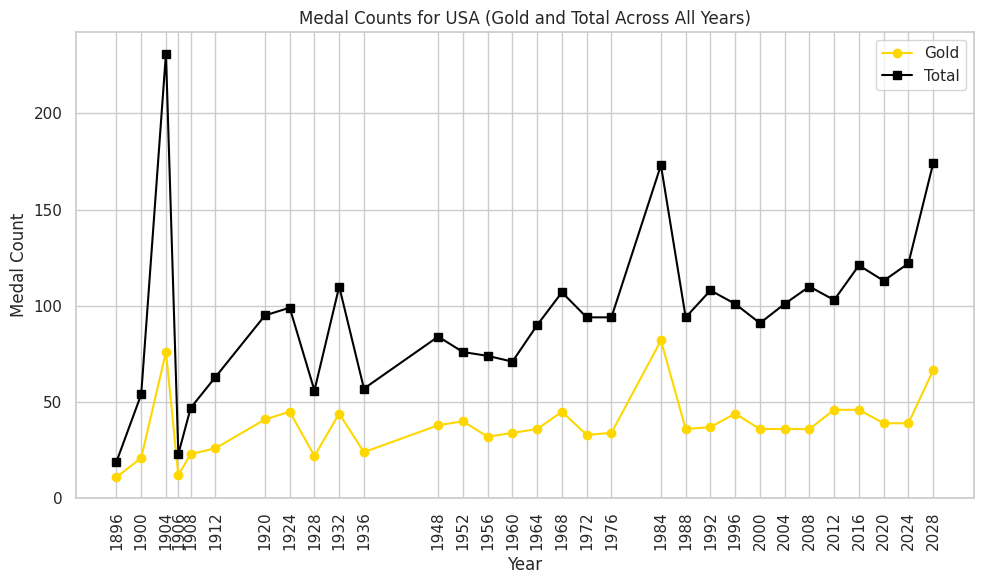

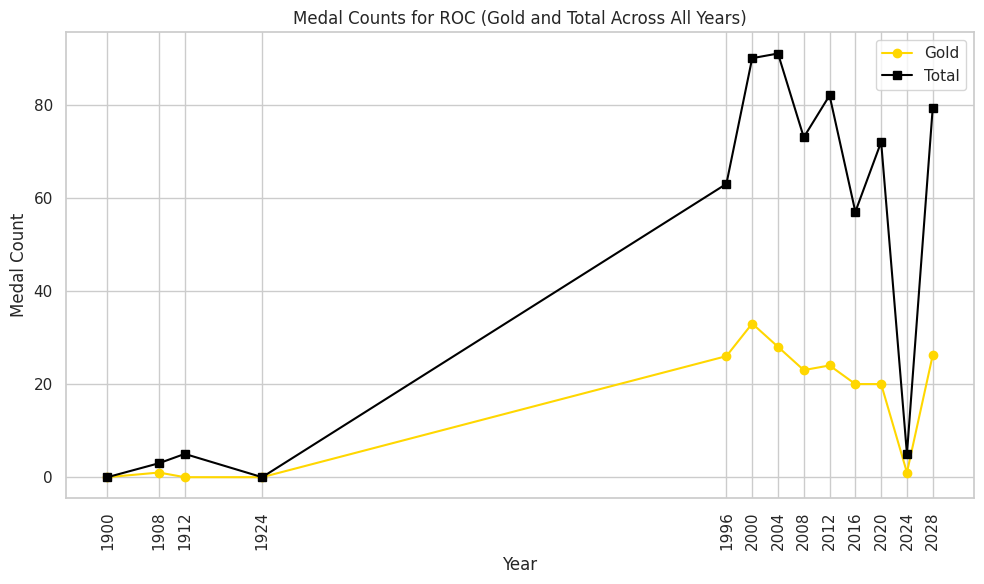

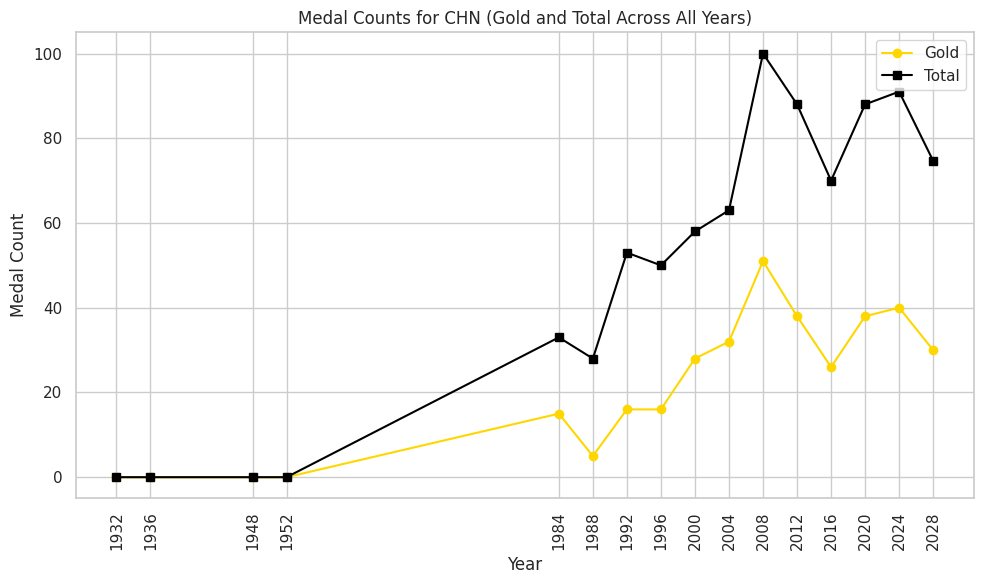

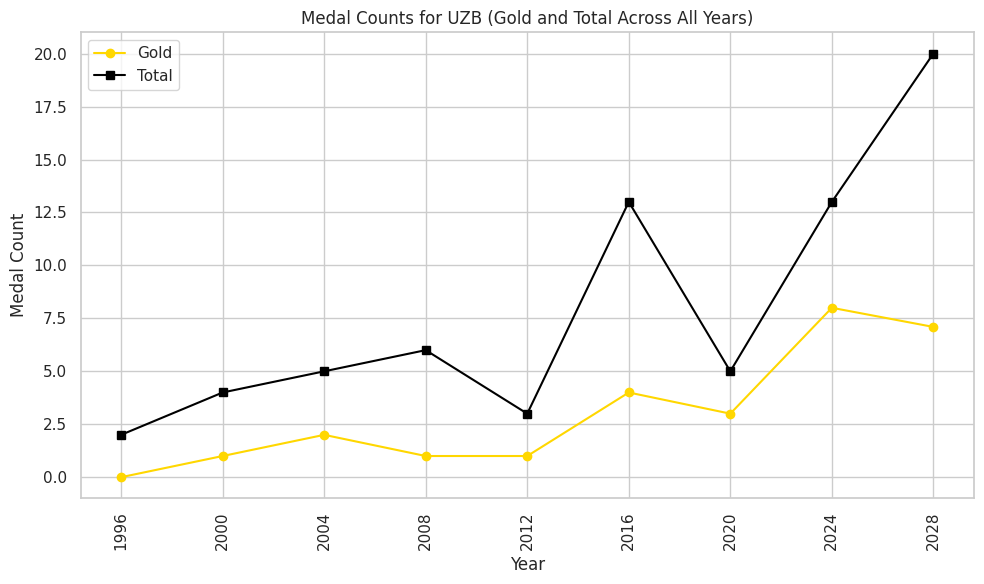

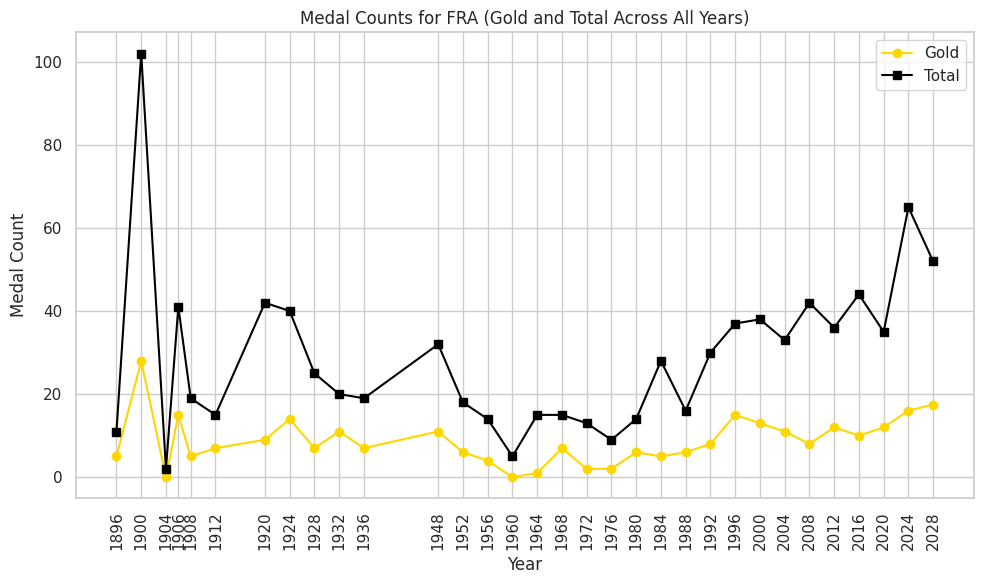

In [41]:
medal_change = medal_country.pivot_table(index='NOC', columns='Year', values=['Gold', 'Total'], aggfunc='sum').reset_index()

medal_change['Gold_Change'] = medal_change[('Gold', 2028)] - medal_change[('Gold', 2024)]
medal_change['Total_Change'] = medal_change[('Total', 2028)] - medal_change[('Total', 2024)]

top_2_gold_max = medal_change.nlargest(2, 'Gold_Change')[['NOC', 'Gold_Change']]
top_2_gold_min = medal_change.nsmallest(2, 'Gold_Change')[['NOC', 'Gold_Change']]
top_2_total_max = medal_change.nlargest(2, 'Total_Change')[['NOC', 'Total_Change']]
top_2_total_min = medal_change.nsmallest(2, 'Total_Change')[['NOC', 'Total_Change']]

selected_nocs = pd.concat([
    top_2_gold_max['NOC'], 
    top_2_gold_min['NOC'], 
    top_2_total_max['NOC'], 
    top_2_total_min['NOC']
]).unique()

gold_improve = top_2_gold_max['NOC'].tolist()
gold_decline = top_2_gold_min['NOC'].tolist()
total_improve = top_2_total_max['NOC'].tolist()
total_decline = top_2_total_min['NOC'].tolist()

print(f"Top 2 improvement in Gold: {', '.join(gold_improve)}")
print(f"Top 2 decline in Gold: {', '.join(gold_decline)}")
print(f"Top 2 improvement in Total: {', '.join(total_improve)}")
print(f"Top 2 decline in Total: {', '.join(total_decline)}")

for noc in selected_nocs:
    noc_data = medal_country[medal_country['NOC'] == noc]
    plt.figure(figsize=(10, 6))
    plt.plot(noc_data['Year'], noc_data['Gold'], label='Gold', marker='o', color='gold')
    plt.plot(noc_data['Year'], noc_data['Total'], label='Total', marker='s', color='black')
    plt.title(f'Medal Counts for {noc} (Gold and Total Across All Years)')
    plt.xlabel('Year')
    plt.ylabel('Medal Count')
    plt.xticks(sorted(noc_data['Year'].unique()), rotation=90)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [63]:
# 1.2. Odds of winning the first Medal
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

X_class_test = X_original[X_original['Year'] == 2028].copy()
X_class_test_vis = X_class_test.copy()
X_class_test['Total'] = X_class_test[['Gold', 'Silver', 'Bronze']].sum(axis=1)
X_class_test['Total'] = np.where(X_class_test['Total'] > 0, 1, 0)
X_class_test = X_class_test.drop(['Year', 'NOC', 'Sport_Code', 'Gold', 'Silver', 'Bronze'], axis=1)
X_class = X_original[X_original['Year'] != 2028].copy()
vis_class = X_class.copy()
X_class['Total'] = X_class[['Gold', 'Silver', 'Bronze']].sum(axis=1)
X_class['Total'] = np.where(X_class['Total'] > 0, 1, 0)
X_class = X_class.drop(['Year', 'NOC', 'Sport_Code', 'Gold', 'Silver', 'Bronze'], axis=1)

y_class = X_class['Total']
X_class = X_class.drop(['Total'], axis=1)

y_class_test = X_class_test['Total']
X_class_test = X_class_test.drop(['Total'], axis=1)

X_class_train, X_class_val, y_class_train, y_class_val = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

scaler = StandardScaler()
X_class_train = scaler.fit_transform(X_class_train)
X_class_val = scaler.transform(X_class_val)
X_class_test = scaler.transform(X_class_test)

y_class_train = y_class_train.astype(int)
class_weight_0 = sum(y_class_train == 0) / len(y_class_train)
class_weight_1 = sum(y_class_train == 1) / len(y_class_train)
class_weights_dict = {0: class_weight_0, 1: class_weight_1}

class_model = Sequential([
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

class_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = class_model.fit(
    X_class_train, y_class_train,
    validation_data=(X_class_val, y_class_val),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

y_val_pred_prob = class_model.predict(X_class_val)
y_val_pred_binary = (y_val_pred_prob > 0.5).astype(int)

print("Validation Classification Report:")
print(classification_report(y_class_val, y_val_pred_binary))

y_test_pred_prob = class_model.predict(X_class_test)
y_test_pred_binary = (y_test_pred_prob > 0.5).astype(int)

X_class_test_vis['Predicted_Medal'] = y_test_pred_binary
X_class_test_vis['Prediction_Probability'] = list(zip(1 - y_test_pred_prob.flatten(), y_test_pred_prob.flatten()))

train['Total'] = train[['Gold', 'Silver', 'Bronze']].sum(axis=1)
noc_year_totals = (
    train[['Year', 'NOC', 'Total']]
    .groupby(['Year', 'NOC'], as_index=False)
    .sum().reset_index()
)
no_medal_nocs = (
    noc_year_totals.groupby('NOC')['Total']
    .sum()
    .reset_index()
)
no_medal_nocs = no_medal_nocs[no_medal_nocs['Total'] == 0]
participated_nocs = train[train['Year'] > 2016]['NOC'].unique()
no_medal_participated_nocs = no_medal_nocs[no_medal_nocs['NOC'].isin(participated_nocs)]
selected_columns = ['Year', 'NOC', 'Sport_Code', 'Predicted_Medal', 'Prediction_Probability']
filtered_predictions = X_class_test_vis[X_class_test_vis['NOC'].isin(no_medal_participated_nocs['NOC'])][selected_columns]

country_probabilities = filtered_predictions.groupby('NOC')['Prediction_Probability'].apply(
    lambda probs: 1 - np.prod([1 - prob[1] for prob in probs])
).reset_index()

country_probabilities.columns = ['NOC', 'Overall_Probability']
country_probabilities['Odds_in_Percent'] = country_probabilities['Overall_Probability'] * 100 / (1 - country_probabilities['Overall_Probability'])
country_probabilities = country_probabilities.sort_values(by='Odds_in_Percent', ascending=False)
country_probabilities

Epoch 1/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8063 - loss: 0.4336 - val_accuracy: 0.8623 - val_loss: 0.3376
Epoch 2/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8525 - loss: 0.3571 - val_accuracy: 0.8631 - val_loss: 0.3281
Epoch 3/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8555 - loss: 0.3418 - val_accuracy: 0.8670 - val_loss: 0.3217
Epoch 4/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8562 - loss: 0.3361 - val_accuracy: 0.8689 - val_loss: 0.3151
Epoch 5/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8586 - loss: 0.3299 - val_accuracy: 0.8710 - val_loss: 0.3099
Epoch 6/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8582 - loss: 0.3272 - val_accuracy: 0.8716 - val_loss: 0.3064
Epoch 7/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8626 - loss: 0.3201 - val_accuracy: 0.8735 - val_loss: 0.3012
Epoch 8/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8619 - loss: 0.3175 - val_accu

,NOC,Overall_Probability,Odds_in_Percent
22,GAM,0.186227,22.884350
36,MAD,0.094842,10.477897
52,SAM,0.086376,9.454251
20,ESA,0.084178,9.191474
40,MLI,0.082494,8.991149
...,...,...,...
62,TUV,0.045140,4.727415
16,CHA,0.044949,4.706455
37,MAW,0.043537,4.551896
9,BIZ,0.024967,2.560601


In [56]:
# Great Coach
train = train[train['Year']!=2028]
A = train.copy()
A.drop(['Year', 'NOC', 'NOC_host', 'Sport_Code'], axis=1, inplace=True)
A = A.dropna()
train = train.loc[A.index].reset_index(drop=True)
A = A.reset_index(drop=True)

X_A = A.drop(['Gold', 'Silver', 'Bronze'], axis=1)
y_A = A[['Gold', 'Silver', 'Bronze']]

X_A_train, X_A_val, y_A_train, y_A_val = train_test_split(
    X_A, y_A, test_size=0.2, random_state=42
)
scaler_A_X = StandardScaler()
scaler_A_y = StandardScaler()

X_A_train = scaler_A_X.fit_transform(X_A_train)
X_A_val = scaler_A_X.transform(X_A_val)

y_A_train_scaled = scaler_A_y.fit_transform(y_A_train)
y_A_val_scaled = scaler_A_y.transform(y_A_val)

A_model = Sequential([
    Dense(128, activation='relu', input_dim=X_A_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='linear')
])

A_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = A_model.fit(
    X_A_train, y_A_train_scaled,
    validation_data=(X_A_val, y_A_val_scaled),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

X_A_scaled = scaler_A_X.transform(X_A)
y_A_pred_scaled = A_model.predict(X_A_scaled)
y_A_pred = scaler_A_y.inverse_transform(y_A_pred_scaled)

train['Predicted_Gold'] = y_A_pred[:, 0]
train['Predicted_Silver'] = y_A_pred[:, 1]
train['Predicted_Bronze'] = y_A_pred[:, 2]

# Prepare the dataset for Great Coach Effect analysis
great_coach = train[['Year', 'NOC', 'Sport_Code', 'Gold', 'Predicted_Gold']].copy()
great_coach['Gold_Change'] = great_coach['Gold'] - great_coach['Predicted_Gold']

# Sort by the largest positive difference
gold_diff = great_coach.sort_values(by='Gold_Change', ascending=False)

# Select the top NOCs with the highest true-predicted difference, ensuring one per NOC
top_3_gold_changes = gold_diff.drop_duplicates(subset=['NOC'], keep='first').nlargest(3, 'Gold_Change')

# Plot historical data for these combinations
for _, row in top_3_gold_changes.iterrows():
    noc = row['NOC']
    sport = row['Sport_Code']
    sport_data = great_coach[
        (great_coach['NOC'] == noc) & (great_coach['Sport_Code'] == sport)
    ]
    
    plt.figure(figsize=(12, 6))
    plt.plot(sport_data['Year'], sport_data['Gold'], label=f'{noc} - {sport} (True Gold)', marker='o', color='blue')
    plt.plot(sport_data['Year'], sport_data['Predicted_Gold'], label=f'{noc} - {sport} (Predicted Gold)', marker='x', color='orange')
    plt.axvline(x=row['Year'], color='red', linestyle='--', label=f"Significant Gold Change ({row['Year']})")
    plt.title(f'Great Coach Effect for {noc} in {sport}')
    plt.xlabel('Year')
    plt.ylabel('Gold Count')
    plt.xticks(sorted(sport_data['Year'].unique()), rotation=90)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Epoch 1/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4782 - mae: 0.3377 - val_loss: 0.2243 - val_mae: 0.2098
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2677 - mae: 0.2448 - val_loss: 0.2216 - val_mae: 0.2110
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2520 - mae: 0.2308 - val_loss: 0.2185 - val_mae: 0.1987
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2412 - mae: 0.2207 - val_loss: 0.2186 - val_mae: 0.1919
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2395 - mae: 0.2167 - val_loss: 0.2221 - val_mae: 0.1958
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2347 - mae: 0.2126 - val_loss: 0.2164 - val_mae: 0.1941
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2321 - mae: 0.2111 - val_loss: 0.2140 - val_mae: 0.1883
Epoch 8/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2368 - mae: 0.2093 - val_loss: 0.2147 - val_mae: 0.1833
Epoch 9/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

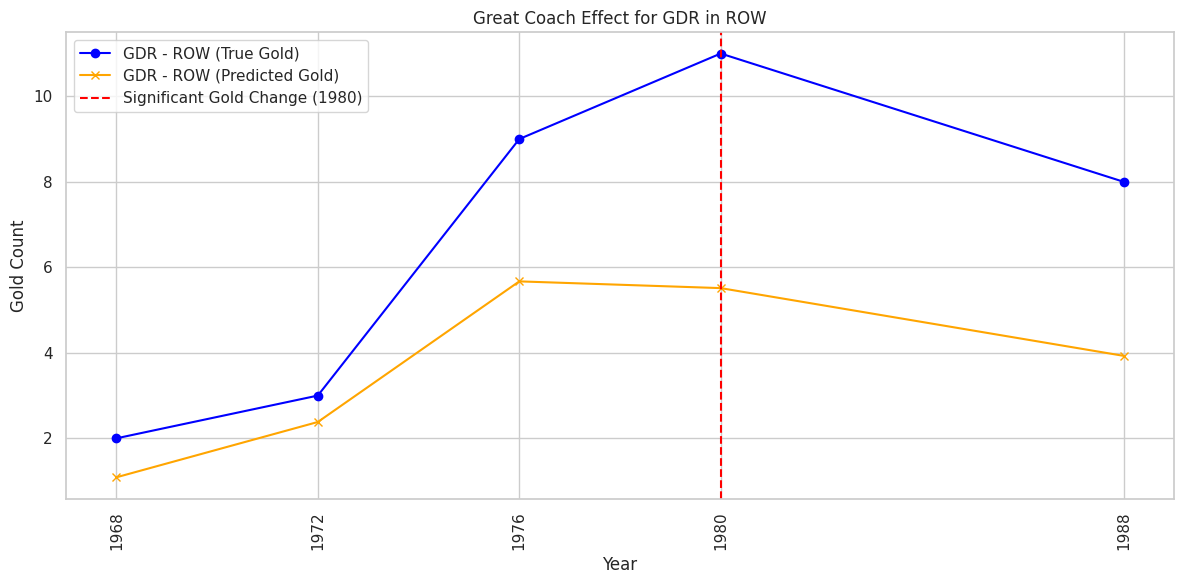

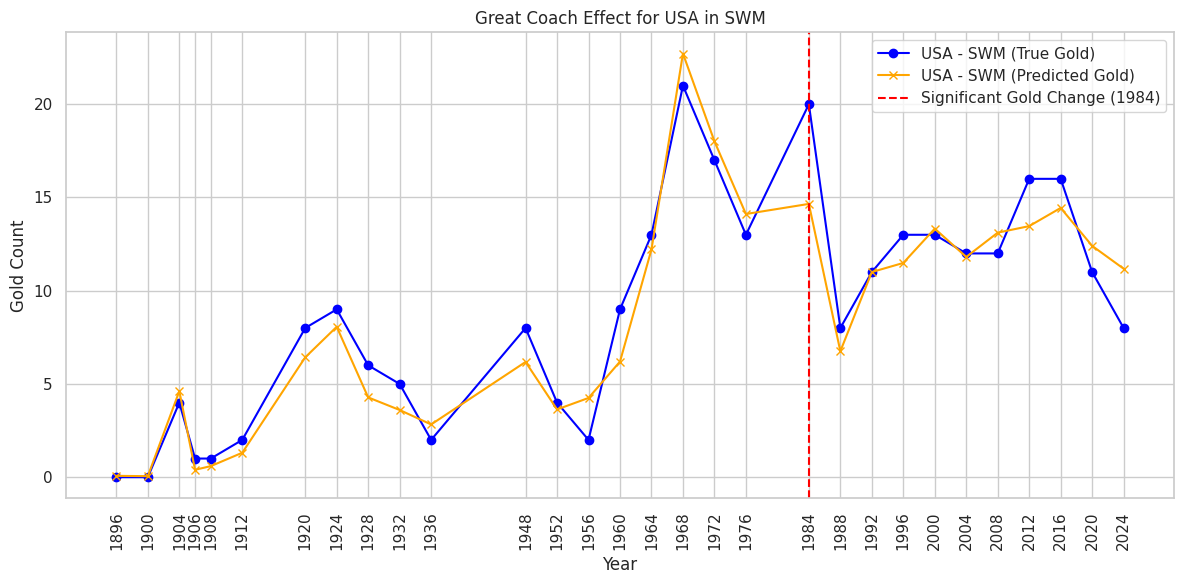

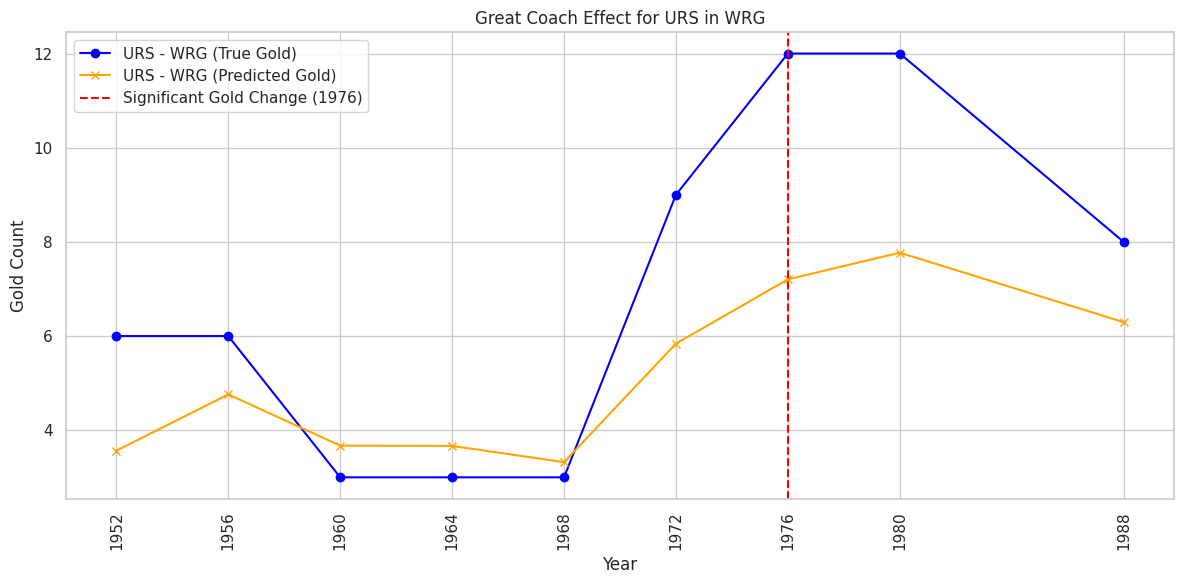